# Project description

Hello everyone!

This project aims to:

* Develop a predictive model for forecasting COVID-19 cases in a specific region, based on historical data aggregated over 7-day windows.
*  Explore potential relationships between weather patterns and COVID-19 case trends during those timeframes.
* The analysis focuses on England's COVID-19 cases, with weather data sourced from an England location.

How am I doing this?

*  Automatically retrieving up-to-date COVID-19 and weather data from public APIs, with programmatic updates at each execution.
*  Performing exploratory data analysis and feature engineering to uncover relevant patterns and construct meaningful inputs.
*  Comparing XGBoost and LightGBM models across various hyperparameter settings.
*  Fine-tuning hyperparameters using walk-forward validation, optimizing for the $R^2$ score across a full year's worth of data.
*  Validating model performance with a target $R^2 > 0.7$, aiming for strong generalization outside of peak-case volatility.

Feel free to reach out if you'd like to discuss this or any of my other GitHub projects!

🔗 LinkedIn – Sebastián Torres Franco

https://www.linkedin.com/in/sebastian-torres-franco-3b3000115/

# Data references and credits


All credits regarding COVID-19 data used in this project to:

* https://ukhsa-dashboard.data.gov.uk/
* https://api.ukhsa-dashboard.data.gov.uk

All creadits regarding weather data to:

* Zippenfenig, P. (2023). Open-Meteo.com Weather API [Computer software]. Zenodo. https://doi.org/10.5281/ZENODO.7970649

* Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023). ERA5 hourly data on single levels from 1940 to present [Data set]. ECMWF. https://doi.org/10.24381/cds.adbb2d47

* Muñoz Sabater, J. (2019). ERA5-Land hourly data from 2001 to present [Data set]. ECMWF. https://doi.org/10.24381/CDS.E2161BAC

* Schimanke S., Ridal M., Le Moigne P., Berggren L., Undén P., Randriamampianina R., Andrea U., Bazile E., Bertelsen A., Brousseau P., Dahlgren P., Edvinsson L., El Said A., Glinton M., Hopsch S., Isaksson L., Mladek R., Olsson E., Verrelle A., Wang Z.Q. (2021). CERRA sub-daily regional reanalysis data for Europe on single levels from 1984 to present [Data set]. ECMWF. https://doi.org/10.24381/CDS.622A565A

# Library and importation

In [2]:
#********************* Library importation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime 
from datetime import date,timedelta
import statsmodels
from statsmodels.tsa.stattools import adfuller,ccf,coint
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.gridspec as gridspec
import xgboost
from xgboost import XGBRegressor
import scipy
from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,r2_score
import lightgbm
from lightgbm import LGBMRegressor
import optuna
import joblib

c:\Users\ingst\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data importation

A snapshot data is taken from previously downloaded files from referenced APIs, and the updated using automated requests to get the most recent information on both COVID-19 positive cases and Weather conditions

## Historical Positive Cases

In [3]:
raw_covid_data=pd.read_csv("ukhsa-chart-download.csv")
raw_covid_data=raw_covid_data[["date","metric_value"]]
print(raw_covid_data.info()) #Checking data types

#*************** Creating and formating the dataframe of historical data 
h_covid_data=pd.DataFrame({
    "Year":[],
    "Month":[],
    "Day":[],
    "Date":[],
    "Cases":[],
})

h_covid_data["Date"]=pd.to_datetime(raw_covid_data["date"],format="ISO8601")
h_covid_data["Month"]=h_covid_data["Date"].dt.month
h_covid_data["Year"]=h_covid_data["Date"].dt.year
h_covid_data["Day"]=h_covid_data["Date"].dt.day
h_covid_data["Cases"]=raw_covid_data["metric_value"]
h_covid_data.sort_values(by="Date",axis="index",inplace=True)
h_covid_data.reset_index(drop=True,inplace=True)
print(h_covid_data.head())

#************** Dumping the dataframe
h_covid_data.to_csv("historical_covid_data.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          388 non-null    object 
 1   metric_value  388 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.2+ KB
None
   Year  Month  Day       Date  Cases
0  2024      4    1 2024-04-01  183.0
1  2024      4    2 2024-04-02  252.0
2  2024      4    3 2024-04-03  207.0
3  2024      4    4 2024-04-04  200.0
4  2024      4    5 2024-04-05  203.0


### Positive cases update

In [ ]:
def data_cases_update(h_covid_data):
    '''
    Description:
        Function that updates historical positive cases (h_covid_data) using an API request from source data and if the date is not duplicated
    Inputs
        h_covid_data (Dataframe): Contains historical covid data that is to be updated    
    Outputs:
        h_covid_data (Dataframe): Updated dataframe
    '''
    curr_date=date.today()
    day_data=curr_date.day      #Check current day for data update
    month_data=curr_date.month
    year_data=curr_date.year
    new_record=True             #Control variable to check for data existence

    while new_record:

        #Request to data source
        url=f"https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_cases_casesByDay?date={year_data}-{month_data}-{day_data}"
        response=requests.get(url)

        #Checking for validity on request
        if response.status_code==200: #Data importation succesful
            data=response.json()
            print("Covid data request succesful with status", response.status_code)
        else:
            print("Covid data request failed with status ",response.status_code)

        #checking for data existnce
        if len(data["results"])>0: #Case data exist take new values          
            curr_date=pd.Timestamp(curr_date)          
  
            if curr_date in h_covid_data.Date.values: #Validate if data is up to date. In case it is end
                 h_covid_data.sort_values(by="Date",axis="index",inplace=True) #Ensure data is sorted
                 h_covid_data.reset_index(drop=True,inplace=True)
                 print(f"Historical data range for Covid-19 positive cases from {h_covid_data.Date.min()} to {h_covid_data.Date.max()}")
                 h_covid_data.to_csv("historical_covid_data.csv")
                 break                              
  
            else:                                   
                print(f"New record added to covid data for date {curr_date}")
                results=data["results"][0]
                new_data=pd.DataFrame({     #Dataframe to concat new info
                        "Year":[pd.to_datetime(results["date"]).year],
                        "Month":[pd.to_datetime(results["date"]).month],
                        "Day":[pd.to_datetime(results["date"]).day],
                        "Date":[pd.to_datetime(results["date"],format="ISO8601")],
                        "Cases":[results["metric_value"]],
                    })
                h_covid_data=pd.concat([h_covid_data,new_data],axis="index",ignore_index=True)
 
                h_covid_data.Date=pd.to_datetime(h_covid_data.Date) #Ensuring format consistency
                h_covid_data.drop_duplicates(ignore_index=True,inplace=True)
                
                curr_date=curr_date-timedelta(1) #Move to next date 
                day_data=curr_date.day           
                month_data=curr_date.month
                year_data=curr_date.year                

        else:
                curr_date=curr_date-timedelta(1) #Take a previous date
                day_data=curr_date.day           #Check current day for data update
                month_data=curr_date.month
                year_data=curr_date.year


    return h_covid_data

h_covid_data=pd.read_csv("historical_covid_data.csv",index_col=0) #Load last update

h_covid_data=data_cases_update(h_covid_data)

Covid data request succesful with status 200
Covid data request succesful with status 200
Covid data request succesful with status 200
Covid data request succesful with status 200
New record added to covid data for date 2025-06-11 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-10 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-09 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-08 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-07 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-06 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-05 00:00:00
Covid data request succesful with status 200
New record added to covid data for date 2025-06-04 00:00:00
Covid data request succes

## Weather data importation

In a similar fashion, weather data is imported from a raw file, and updated via APIs

### Historical weather data

In [42]:
#*********** Reading and renaming columns
raw_weath_data=pd.read_csv("open-meteo-54.73N2.85W71m.csv",skiprows=3)

#*************** Creating and formating the dataframe of historical data 
h_weath_data=pd.DataFrame({
    "Year":[],
    "Month":[],
    "Day":[],
    "Date":[],
    "Mean_Temperature":[],
    "Max_Temperature":[],
    "Min_Temperature":[],
    "Max_Wind_Speed":[],
    "Precipitation_Hours":[],
    "Rain_Sum":[],
    "Snowfall_Sum":[],

})

h_weath_data["Date"]=pd.to_datetime(raw_weath_data["time"])
h_weath_data["Month"]=h_weath_data["Date"].dt.month
h_weath_data["Year"]=h_weath_data["Date"].dt.year
h_weath_data["Day"]=h_weath_data["Date"].dt.day
h_weath_data["Mean_Temperature"]=raw_weath_data["temperature_2m_mean (°C)"]
h_weath_data["Min_Temperature"]=raw_weath_data["temperature_2m_min (°C)"]
h_weath_data["Max_Temperature"]=raw_weath_data["temperature_2m_max (°C)"]
h_weath_data["Max_Wind_Speed"]=raw_weath_data["wind_speed_10m_mean (km/h)"]
h_weath_data["Precipitation_Hours"]=raw_weath_data["precipitation_hours (h)"]
h_weath_data["Rain_Sum"]=raw_weath_data["rain_sum (mm)"]
h_weath_data["Snowfall_Sum"]=raw_weath_data["snowfall_sum (cm)"]

print(h_weath_data.info())

h_weath_data.head()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year                 393 non-null    int32         
 1   Month                393 non-null    int32         
 2   Day                  393 non-null    int32         
 3   Date                 393 non-null    datetime64[ns]
 4   Mean_Temperature     391 non-null    float64       
 5   Max_Temperature      392 non-null    float64       
 6   Min_Temperature      392 non-null    float64       
 7   Max_Wind_Speed       391 non-null    float64       
 8   Precipitation_Hours  393 non-null    float64       
 9   Rain_Sum             391 non-null    float64       
 10  Snowfall_Sum         391 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int32(3)
memory usage: 29.3 KB
None


,Year,Month,Day,Date,Mean_Temperature,Max_Temperature,Min_Temperature,Max_Wind_Speed,Precipitation_Hours,Rain_Sum,Snowfall_Sum
0,2024,4,1,2024-04-01,6.4,8.1,5.2,9.6,17.0,7.7,0.0
1,2024,4,2,2024-04-02,7.1,9.7,4.6,4.4,12.0,5.2,0.0
2,2024,4,3,2024-04-03,7.4,10.0,4.2,10.1,13.0,9.7,0.0
3,2024,4,4,2024-04-04,6.6,9.6,3.9,9.5,6.0,2.2,0.0
4,2024,4,5,2024-04-05,10.3,13.5,5.1,22.9,14.0,12.3,0.0


In [6]:
#************** Filling NA and Dumping the dataframe
h_weath_data.ffill(inplace=True)
h_weath_data.info()
h_weath_data.to_csv("historical_weather_data.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year                 393 non-null    int32         
 1   Month                393 non-null    int32         
 2   Day                  393 non-null    int32         
 3   Date                 393 non-null    datetime64[ns]
 4   Mean_Temperature     393 non-null    float64       
 5   Max_Temperature      393 non-null    float64       
 6   Min_Temperature      393 non-null    float64       
 7   Max_Wind_Speed       393 non-null    float64       
 8   Precipitation_Hours  393 non-null    float64       
 9   Rain_Sum             393 non-null    float64       
 10  Snowfall_Sum         393 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int32(3)
memory usage: 29.3 KB


### Weather data update

In [43]:
def weather_update(h_weath_data):
    '''
    Description:
        Function to check for updates on the historical weather data based on a rolling windows of 7 days starting from the last known covid positive cases update
    Inputs:
        h_weath_data: Dataframe with historical weather data that is to be updated
    Outputs:
        h_weath_data: Updated dataframe    
    '''
    #******************************* Date range for historical data
    #Starting point for update
    last_date=pd.to_datetime(h_weath_data.Date.max())
    last_weath_year=last_date.year
    last_weath_month=f"{last_date.month:02d}"
    last_weath_day=f"{last_date.day:02d}"

    #Limit for historical data
    curr_date=date.today()
    day_data=f"{curr_date.day:02d}"     #Check current day for data update
    month_data=f"{curr_date.month:02d}"
    year_data=curr_date.year
    
    #Request to data source. Forecast data is used to avoid possible missing data from historical records
    url=f"https://api.open-meteo.com/v1/forecast?latitude=54.7584&longitude=-2.6953&start_date={last_weath_year}-{last_weath_month}-{last_weath_day}&end_date={year_data}-{month_data}-{day_data}&daily=temperature_2m_mean,temperature_2m_max,temperature_2m_min,wind_speed_10m_max,precipitation_hours,rain_sum,snowfall_sum&timezone=Europe%2FLondon"
    response=requests.get(url)

    #Checking for validity on request
    if response.status_code==200: #Data importation succesful
        data=response.json()
        print("Weather data request succesful with status", response.status_code)
    else:
        print("Weather data request failed with status ",response.status_code)
        return None
    
    #******************************* Updating dataframe
    if "daily" not in data.keys():
        print("Void data record. Check source")
        return h_weath_data
    else:
        results=data["daily"]
        dates=pd.to_datetime(results["time"])
        new_data=pd.DataFrame({
                "Year":dates.year,
                "Month":dates.month,
                "Day":dates.day,
                "Date":dates,
                "Mean_Temperature":results["temperature_2m_mean"],
                "Max_Temperature":results["temperature_2m_max"],
                "Min_Temperature":results["temperature_2m_min"],
                "Max_Wind_Speed":results["wind_speed_10m_max"],
                "Precipitation_Hours":results["precipitation_hours"],
                "Rain_Sum":results["rain_sum"],
                "Snowfall_Sum":results["snowfall_sum"],
            })

        new_data.dropna(axis="index",how="any",inplace=True)  #Cleaning empty records from new data
        h_weath_data=pd.concat([h_weath_data,new_data],axis="index",ignore_index=True)
        h_weath_data.Date=pd.to_datetime(h_weath_data.Date)    #Ensuring Date format
        h_weath_data.drop_duplicates(subset=["Date"],ignore_index=True,inplace=True)

        h_weath_data.to_csv("historical_weather_data.csv")

        print(f"New historical records added for weather conditions for dates {results["time"]}")
        print(f"Weather record range from {h_weath_data.Date.min()} to {h_weath_data.Date.max()}")

    return h_weath_data

#**************** Updating the historical records of weather
h_weath_data=pd.read_csv("historical_weather_data.csv",index_col=0)
h_weath_data=weather_update(h_weath_data)

Weather data request succesful with status 200
New historical records added for weather conditions for dates ['2025-06-14', '2025-06-15', '2025-06-16', '2025-06-17']
Weather record range from 2024-04-01 00:00:00 to 2025-06-17 00:00:00


# Data Exploration

Highlights:
* Covid data show both peaks and valleys
* Temperature features exhibit likely seasonal behavior, where as remaining weather features show an erratic trend

# Series plot

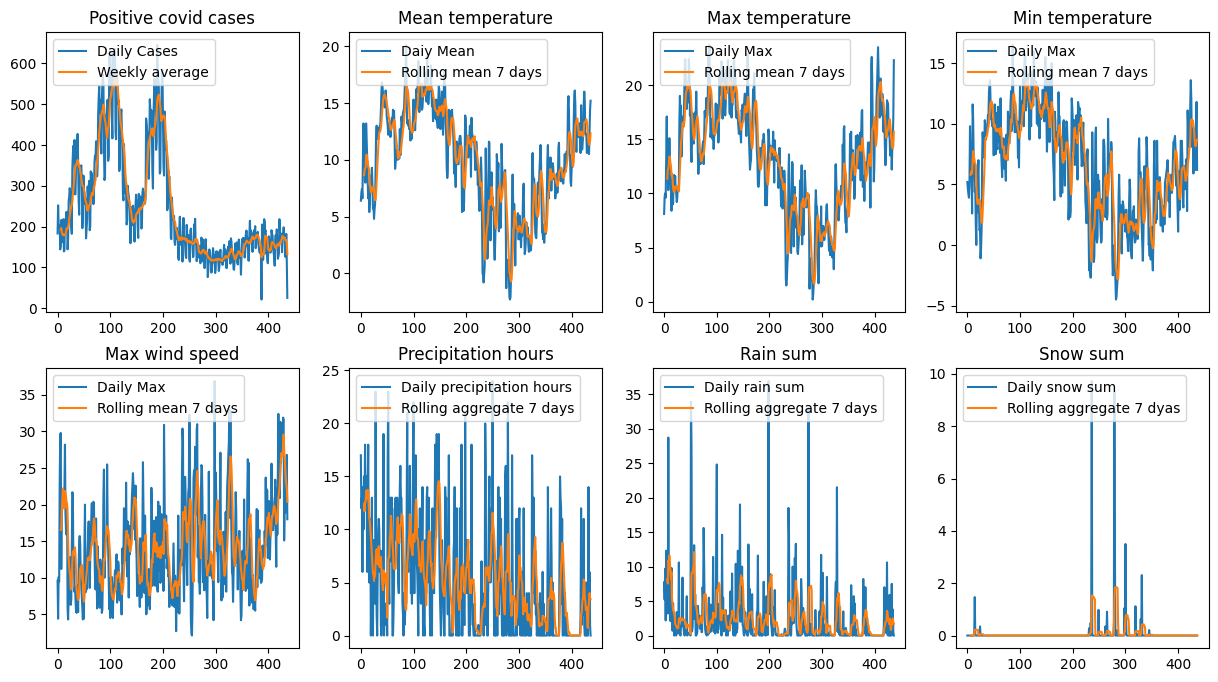

In [8]:
#************** Taking date range in common for plotting
min_date_weath=h_weath_data.Date.min()
max_date_weath=h_weath_data.Date.max()
min_date_covid=h_covid_data.Date.min()
max_date_covid=h_covid_data.Date.max()
min_date=max(min_date_covid,min_date_weath)
max_date=min(max_date_covid,max_date_weath)
h_covid_data=h_covid_data[(h_covid_data.Date>=min_date) & (h_covid_data.Date<=max_date)]
h_weath_data=h_weath_data[(h_weath_data.Date>=min_date) & (h_weath_data.Date<=max_date)]

#************* Plotting
fig,axs=plt.subplots(2,4,figsize=(15,8))
h_covid_data[["Cases"]].plot(kind="line",ax=axs[0,0])
h_covid_data[["Cases"]].rolling(window=7).mean().plot(kind="line",ax=axs[0,0])
axs[0,0].set_title("Positive covid cases")
axs[0,0].legend(["Daily Cases","Weekly average"],loc="upper left")

h_weath_data[["Mean_Temperature"]].plot(kind="line",ax=axs[0,1])
h_weath_data[["Mean_Temperature"]].rolling(window=7).mean().plot(kind="line",ax=axs[0,1])
axs[0,1].set_title("Mean temperature")
axs[0,1].legend(["Daiy Mean","Rolling mean 7 days"],loc="upper left")

h_weath_data[["Max_Temperature"]].plot(kind="line",ax=axs[0,2])
h_weath_data[["Max_Temperature"]].rolling(window=7).mean().plot(kind="line",ax=axs[0,2])
axs[0,2].set_title("Max temperature")
axs[0,2].legend(["Daily Max","Rolling mean 7 days"],loc="upper left")

h_weath_data[["Min_Temperature"]].plot(kind="line",ax=axs[0,3])
h_weath_data[["Min_Temperature"]].rolling(window=7).mean().plot(kind="line",ax=axs[0,3])
axs[0,3].set_title("Min temperature")
axs[0,3].legend(["Daily Max","Rolling mean 7 days"],loc="upper left")

h_weath_data[["Max_Wind_Speed"]].plot(kind="line",ax=axs[1,0])
h_weath_data[["Max_Wind_Speed"]].rolling(window=7).mean().plot(kind="line",ax=axs[1,0])
axs[1,0].set_title("Max wind speed")
axs[1,0].legend(["Daily Max","Rolling mean 7 days"],loc="upper left")

h_weath_data[["Precipitation_Hours"]].plot(kind="line",ax=axs[1,1])
h_weath_data[["Precipitation_Hours"]].rolling(window=7).mean().plot(kind="line",ax=axs[1,1])
axs[1,1].set_title("Precipitation hours")
axs[1,1].legend(["Daily precipitation hours","Rolling aggregate 7 days"],loc="upper left")

h_weath_data[["Rain_Sum"]].plot(kind="line",ax=axs[1,2])
h_weath_data[["Rain_Sum"]].rolling(window=7).mean().plot(kind="line",ax=axs[1,2])
axs[1,2].set_title("Rain sum")
axs[1,2].legend(["Daily rain sum","Rolling aggregate 7 days"],loc="upper left")

h_weath_data[["Snowfall_Sum"]].plot(kind="line",ax=axs[1,3])
h_weath_data[["Snowfall_Sum"]].rolling(window=7).mean().plot(kind="line",ax=axs[1,3])
axs[1,3].set_title("Snow sum")
axs[1,3].legend(["Daily snow sum","Rolling aggregate 7 dyas"],loc="upper left")



## Lag Plot

No significant change in the relation between lagged weather conditions and covid cases

Speculation: Higher temperatures imply higher transmision rates since people are more outdoors

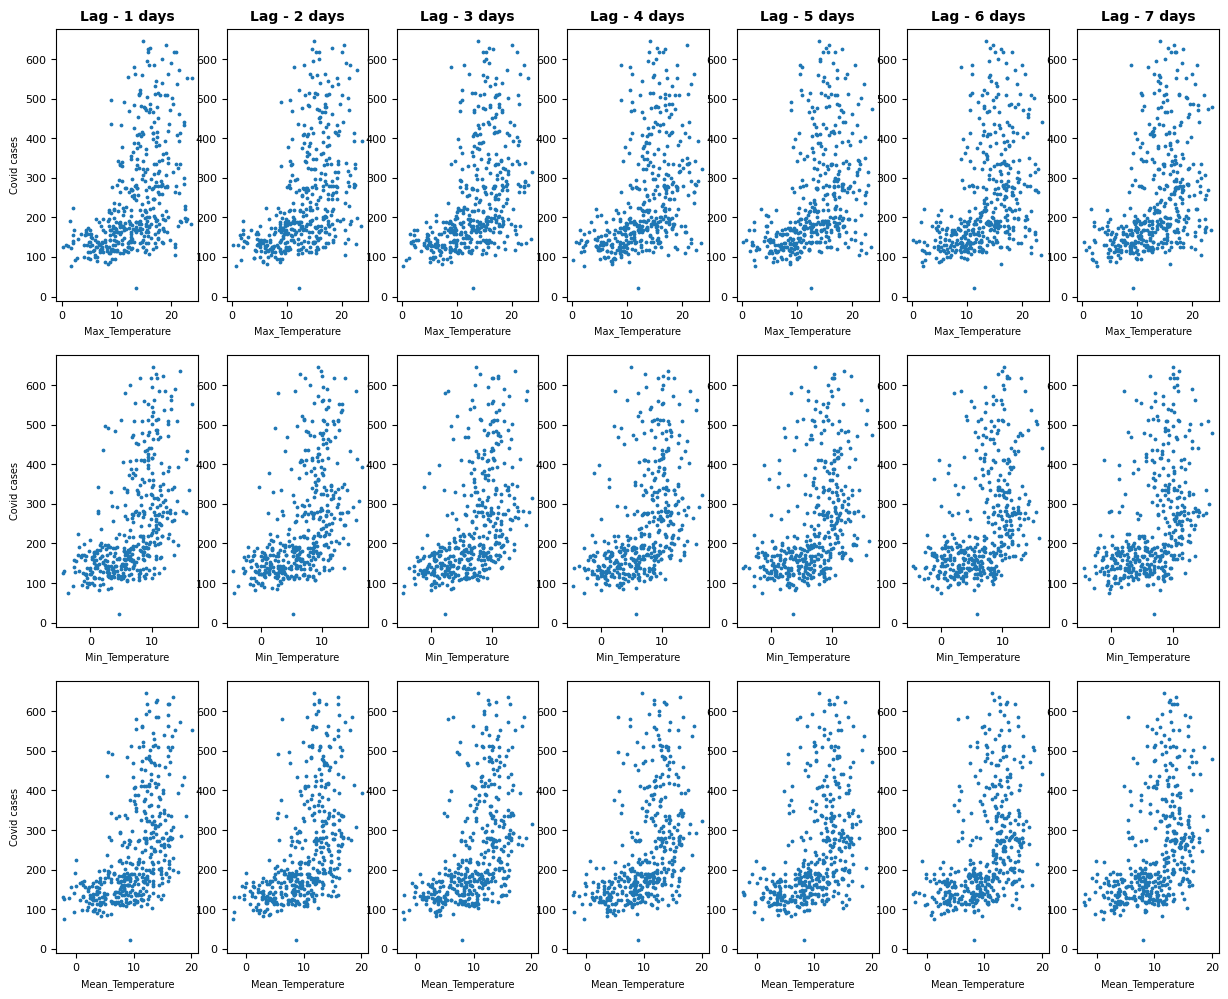

In [9]:
#************ Creating lagplots to verify COVID cases relation to weather conditions based on a 1 to 7 day lag.
#             Covid data is set as static, and weather data is lagged.

#Plots considered vs Mean temperature, Min temperature, Max temperature as they showed the highest correlation
weath_data_to_lag=h_weath_data[["Date","Max_Temperature","Min_Temperature","Mean_Temperature"]]

#Getting matching dates
min_date=max(h_covid_data.Date.min(),weath_data_to_lag.Date.min())
max_date=min(h_covid_data.Date.max(),weath_data_to_lag.Date.max())

x_data=weath_data_to_lag[(weath_data_to_lag.Date>min_date) & (weath_data_to_lag.Date<max_date)]
x_data.reset_index(drop=True,inplace=True)

y_data=h_covid_data[(h_covid_data.Date>min_date) & (h_covid_data.Date<max_date)]
y_data.reset_index(drop=True,inplace=True)
y_data=y_data.loc[7:,"Cases"] #Static covid data
                   
#Lag plots
fig,axs=plt.subplots(3,7,figsize=(15,12))
#plt.tight_layout()
for i in range(3):
    for j in range(1,8):
        #Creating the lag
        start=7-j
        end=len(x_data)-1-j
        feature=weath_data_to_lag.columns[i+1]
        axs[i,j-1].scatter(x_data.loc[start:end,feature],y_data,s=3)
        axs[i,j-1].set_xlabel(feature,fontsize=7)
        axs[i,j-1].tick_params(axis="x",labelsize=8)
        axs[i,j-1].tick_params(axis="y",labelsize=8)
        
        if i==0: axs[i,j-1].set_title(f"Lag - {j} days",fontdict={"size":10,"weight":"bold"})
        if j==1: axs[i,j-1].set_ylabel("Covid cases",fontsize=7)


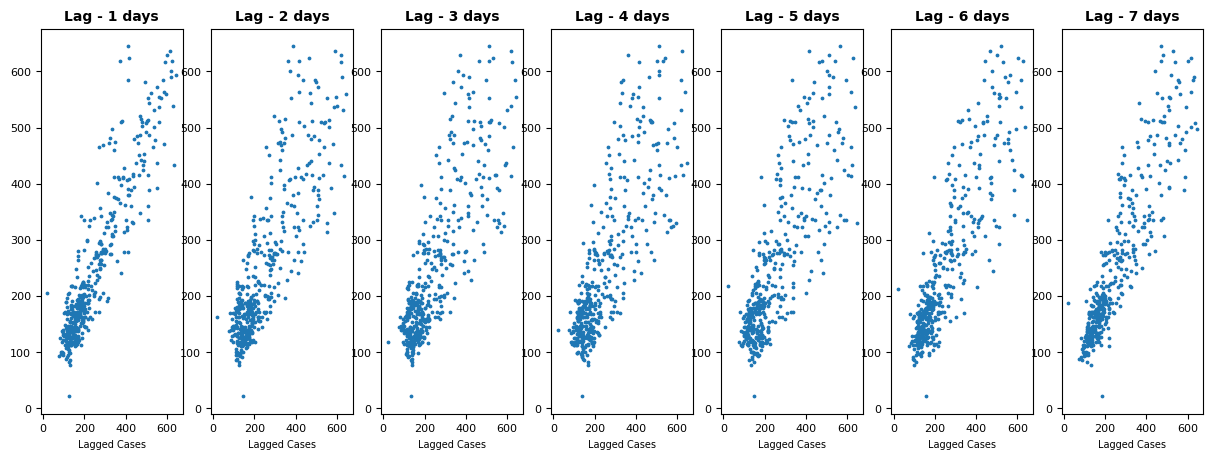

In [10]:
# covid lag plots 
x_data=h_covid_data[(h_covid_data.Date>min_date) & (h_covid_data.Date<max_date)]
fig, axs = plt.subplots(1, 7, figsize=(15, 5))
for j in range(1, 8):
    x_lag = x_data["Cases"].shift(j).dropna().reset_index(drop=True)
    y_static = x_data["Cases"].iloc[j:].reset_index(drop=True)
    axs[j - 1].scatter(x_lag, y_static, s=3)
    axs[j - 1].set_xlabel("Lagged Cases", fontsize=7)
    axs[j - 1].tick_params(axis="x", labelsize=8)
    axs[j - 1].tick_params(axis="y", labelsize=8)
    axs[j - 1].set_title(f"Lag - {j} days", fontdict={"size":10, "weight":"bold"})

# Outlier detection

Highlights:
* Outlier detection is done busing a rolling window and a Z-score criteria
* No outliers where detected

In [11]:
def outlier_detection(time_s,window,target_var):
    ''' 
    Description:
        Function to detect outliers in a given time series. The outliers are detected over residuals using a rolling window of n days with a 3 standard deviation criteria
    Inptuts
        time_s: time series upon which outliers are detected
        window_days= window to consier for outlier detection
        target_var=  Colunmn name of the variable to analyze
    Returns
        outlier_date: List of dates detected as outliers
    '''

    #************** Computing trend to for residual calculation
    trend=time_s[target_var].rolling(window=window,center=True).mean()
    residual=time_s[target_var]-trend

    #************* Z calculation and outlier detection
    residual_mean=(residual.rolling(window=window).mean())
    residual_std=(residual.rolling(window=window).std())
    residual_zscore=(residual-residual_mean)/residual_std

    residual_zscore.dropna(inplace=True)

    outlier_zscore=residual_zscore[abs(residual_zscore)>=3]#Taking date with outliers

    if len(outlier_zscore)==0: #Case no outliers
        return []
    else:
        outlier_index=outlier_zscore.index
        outlier_date=time_s.loc[outlier_index,"Date"].tolist()    
        return outlier_date

#************************ Outlier detection
#Covid Outlier detection
covid_outliers=outlier_detection(h_covid_data,7,"Cases")

#Weather variable outlier detection
mean_temp_outliers=outlier_detection(h_weath_data,7,"Mean_Temperature")
max_temp_outliers=outlier_detection(h_weath_data,7,"Max_Temperature")
min_temp_outliers=outlier_detection(h_weath_data,7,"Min_Temperature")
max_wind_outliers=outlier_detection(h_weath_data,7,"Max_Wind_Speed")
precipitation_outliers=outlier_detection(h_weath_data,7,"Precipitation_Hours")
rain_outliers=outlier_detection(h_weath_data,7,"Rain_Sum")
snow_outliers=outlier_detection(h_weath_data,7,"Snowfall_Sum")

#************************ Outlier print

print("Covid cases outliers")
print(covid_outliers)

print("Mean temperature Outliers")
print(mean_temp_outliers)

print("Max temperature Outliers")
print(max_temp_outliers)

print("Min temperature Outliers")
print(min_temp_outliers)

print("Max wind Outliers")
print(max_wind_outliers)

print("Precipitation outliers")
print(precipitation_outliers)

print("Rain sum outliers")
print(rain_outliers)

print("Snow sum outliers")
print(snow_outliers)

Covid cases outliers
[]
Mean temperature Outliers
[]
Max temperature Outliers
[]
Min temperature Outliers
[]
Max wind Outliers
[]
Precipitation outliers
[]
Rain sum outliers
[]
Snow sum outliers
[]


# Stationarity check

ADF test is computed to check for stationarity in the downloaded features.

Highlights:
* Temperatures exhibit non stationarity which could be alluded to seasonality
* Covid cases are not stationary as expected, however, data exploration does not show a clear trend of seasonality


In [44]:
def adf_test(t_series,target_var,confidence,key):
    '''
    Description:
        Function to perform ADF test on time series to check for stationarity
    Inputs:
        t_series: Time series to check for stationarity
        target_var: Column name of the variable to analyze
        confidence: Confidence level set as threshold
        key: Print key for treaceability
    Outputs:
        stat_id: 1 if series is stationary 0 if not.  
    '''

    result = adfuller(t_series[target_var].dropna())
    adf_statistic=result[0]
    p_value=result[1]
    critical_values=result[4]
    print(f"\n------ ADF FOR {key} ------")
    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')
    print("Critical values:")

    for level,value in critical_values.items():
        print(f"    {level}: {value:.4f}")
    if p_value > (1-confidence):
        print(f"Time series {key} non stationary according to ADF test")
        return 0
    else:
        print(f"Time series {key}  stationary according to ADF test")
        return 1

stat_covid=adf_test(h_covid_data,"Cases",0.95,"Covid series")
stat_mean_temp=adf_test(h_weath_data,"Mean_Temperature",0.95,"Mean temperature series")
stat_min_temp=adf_test(h_weath_data,"Min_Temperature",0.95,"Min temperature series")
stat_max_temp=adf_test(h_weath_data,"Max_Temperature",0.95,"Max temperature series")
stat_max_wind=adf_test(h_weath_data,"Max_Wind_Speed",0.95,"Max wind speed series")
stat_precip=adf_test(h_weath_data,"Precipitation_Hours",0.95,"Precipitation hours temperature series")
stat_rain=adf_test(h_weath_data,"Rain_Sum",0.95,"Rain sum time series")
stat_snow=adf_test(h_weath_data,"Snowfall_Sum",0.95,"Snow sum time series")




------ ADF FOR Covid series ------
ADF Statistic: -2.0580
p-value: 0.2617
Critical values:
    1%: -3.4462
    5%: -2.8685
    10%: -2.5705
Time series Covid series non stationary according to ADF test

------ ADF FOR Mean temperature series ------
ADF Statistic: -2.4720
p-value: 0.1224
Critical values:
    1%: -3.4454
    5%: -2.8682
    10%: -2.5703
Time series Mean temperature series non stationary according to ADF test

------ ADF FOR Min temperature series ------
ADF Statistic: -2.8666
p-value: 0.0494
Critical values:
    1%: -3.4454
    5%: -2.8682
    10%: -2.5703
Time series Min temperature series  stationary according to ADF test

------ ADF FOR Max temperature series ------
ADF Statistic: -1.4975
p-value: 0.5347
Critical values:
    1%: -3.4458
    5%: -2.8683
    10%: -2.5704
Time series Max temperature series non stationary according to ADF test

------ ADF FOR Max wind speed series ------
ADF Statistic: -10.2736
p-value: 0.0000
Critical values:
    1%: -3.4452
    5%: -2.

# Feature Engineering

Highlights:
* Derived features are generated from existing data to add value to input data.
* Aggregated covid cases over 1 week window are elaborated as this is the target of prediction
* Correlation and cointegration is studied between features and those who show little. Only those features that exhibited strong correlation are kept for the model development.
* Fourier components where computed for non stationary features different from covid cases, as it is assumed that this condition is due to stationality

## Derived features

In [46]:
#****************** Weather derived features
# Temperature range
h_weath_data["Temperature_Range"]=h_weath_data["Max_Temperature"]-h_weath_data["Min_Temperature"]
h_weath_data["Temperature_Range"]=round(h_weath_data["Temperature_Range"],2)

# Delta Temperature 
h_weath_data["Temperature_Delta"]=np.zeros(shape=(len(h_weath_data)))
h_weath_data["Temperature_Delta"] = h_weath_data["Mean_Temperature"].diff()
h_weath_data["Temperature_Delta"]=round(h_weath_data["Temperature_Delta"],2)

# Rolling mean
h_weath_data["Rolling_Mean_Mean_Temp"]=h_weath_data["Mean_Temperature"].rolling(window=7).mean()
h_weath_data["Rolling_Mean_Min_Temp"]=h_weath_data["Min_Temperature"].rolling(window=7).mean()
h_weath_data["Rolling_Mean_Max_Temp"]=h_weath_data["Max_Temperature"].rolling(window=7).mean()


#****************** Covid derived features
# Rolling aggregate
h_covid_data["Cases_Agg"]=h_covid_data["Cases"].rolling(window=7).sum() #This will be the target feature!!!!!


#****************** Lagged data for 3 5 7 days for both covid data and weather data

for i in range(3,9):
    #Lagged data for covid
    h_covid_data[f"Cases_lag{i}"]=h_covid_data[["Cases"]].shift(i).values

    #Lagged data for weather
    h_weath_data[f"Max_temp_lag{i}"]=h_weath_data[["Max_Temperature"]].shift(i).values
    h_weath_data[f"Mean_temp_lag{i}"]=h_weath_data[["Mean_Temperature"]].shift(i).values
    h_weath_data[f"Min_temp_lag{i}"]=h_weath_data[["Min_Temperature"]].shift(i).values

# Droping NAN

h_covid_data.dropna(inplace=True)
h_weath_data.dropna(inplace=True)



## Relation between series

Highlights:
* Precipitation_Hours, Rain_Sum, Snowfall_Sum, Temperature_Range, Temperature_Delta had little relation to the target feature, and where dropped from the dataset.

In [47]:
def relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary):
    '''
    Description:
        Function used to analyze the relation between a target series and a secondary series
        If both series are stationary cross correlation is used to compute correlation at different time lags
        If at least 1 series is non stationary cointegration y used along with correlation to check for relation
    
    Inputs
        target_df (Dataframe): Dataframe containing the target variable of the study
        type_target (int): 0 if target_series is non stationary else 1
        target_var (str): Column name for target variable
        key_target (str): target series id defined by user for traceability
        secondary_df (Dataframe): Dataframe containing the secondary features to consider
        type_secondary (int): 0 if secondary_series is non stationary 1 if else
        secondary_var (str): Column name for secondary variable
        key_secondary (str): target series id defined by user for traceability

    Returns None
    '''
    min_date=max(target_df.Date.min(),secondary_df.Date.min())
    max_date=min(target_df.Date.max(),secondary_df.Date.max())
    
    x=target_df[(target_df.Date>=min_date) & (target_df.Date<=max_date)][target_var]
    y=secondary_df[(secondary_df.Date>=min_date) & (secondary_df.Date<=max_date)][secondary_var]

    print(f" ---------- Relation Between {key_target} and {key_secondary}: ----------")
    if (type_target==1) | (type_secondary==1):
        print(f"Type of relation : Cross Correlation")
        cross_corr=ccf(x,y)
        for lag,value in enumerate(cross_corr[:15]):
            print(f"- lag {lag} - Cross correlation: {value:.4f}")
   
    else:
        print(f"Type of relation : Cointegration + Correlation")
        c_coint=coint(x,y,"n")
        corr=np.corrcoef(x,y)[0,1]
        print(f"Cointegration: {c_coint[1]:.4f}")
        print(f"correlation: {corr:.4f}\n")
    
    return None

#**************************** Checking relation between series
#Target variable
target_df=h_covid_data
type_target=0
target_var="Cases"
key_target="Covid Cases"

#Mean Temperature
secondary_df=h_weath_data
type_secondary=0
secondary_var="Mean_Temperature"
key_secondary="Mean temperature "
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Min Temperature
secondary_df=h_weath_data
type_secondary=0
secondary_var="Min_Temperature"
key_secondary="Min temperature "
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Max Temperature
secondary_df=h_weath_data
type_secondary=0
secondary_var="Max_Temperature"
key_secondary="Max temperature "
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Precipitation
secondary_df=h_weath_data
type_secondary=0
secondary_var="Precipitation_Hours"
key_secondary="Precipitation hours"
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Max Wind speed
secondary_df=h_weath_data
type_secondary=0
secondary_var="Max_Wind_Speed"
key_secondary="Max Wind Speed"
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Rain
secondary_df=h_weath_data
type_secondary=0
secondary_var="Rain_Sum"
key_secondary="Rain sum"
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Snow
secondary_df=h_weath_data
type_secondary=0
secondary_var="Snowfall_Sum"
key_secondary="Snow sum"
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Temperature Range
secondary_df=h_weath_data
type_secondary=0
secondary_var="Temperature_Range"
key_secondary="Temp range"
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)

#Temperature Delta
secondary_df=h_weath_data
type_secondary=0
secondary_var="Temperature_Delta"
key_secondary="Temp delta"
relation_series(target_df,type_target,target_var,key_target,secondary_df,type_secondary,secondary_var,key_secondary)


 ---------- Relation Between Covid Cases and Mean temperature : ----------
Type of relation : Cointegration + Correlation
Cointegration: 0.0832
correlation: 0.5405

 ---------- Relation Between Covid Cases and Min temperature : ----------
Type of relation : Cointegration + Correlation
Cointegration: 0.0249
correlation: 0.5480

 ---------- Relation Between Covid Cases and Max temperature : ----------
Type of relation : Cointegration + Correlation
Cointegration: 0.1598
correlation: 0.4934

 ---------- Relation Between Covid Cases and Precipitation hours: ----------
Type of relation : Cointegration + Correlation
Cointegration: 0.3584
correlation: 0.2194

 ---------- Relation Between Covid Cases and Max Wind Speed: ----------
Type of relation : Cointegration + Correlation
Cointegration: 0.3657
correlation: -0.2402

 ---------- Relation Between Covid Cases and Rain sum: ----------
Type of relation : Cointegration + Correlation
Cointegration: 0.4181
correlation: 0.1290

 ---------- Relation 

In [15]:
#Dropping low correlated +Cointegrated features
h_weath_data.drop(["Precipitation_Hours","Rain_Sum","Snowfall_Sum","Temperature_Range","Temperature_Delta"],axis="columns",inplace=True)
h_weath_data.head()

,Year,Month,Day,Date,Mean_Temperature,Max_Temperature,Min_Temperature,Max_Wind_Speed,Rolling_Mean_Mean_Temp,Rolling_Mean_Min_Temp,...,Min_temp_lag5,Max_temp_lag6,Mean_temp_lag6,Min_temp_lag6,Max_temp_lag7,Mean_temp_lag7,Min_temp_lag7,Max_temp_lag8,Mean_temp_lag8,Min_temp_lag8
8,2024,4,9,2024-04-09,8.0,10.3,5.5,20.9,9.242857,6.114286,...,3.9,10.0,7.4,4.2,9.7,7.1,4.6,8.1,6.4,5.2
9,2024,4,10,2024-04-10,8.0,12.4,2.6,19.9,9.328571,5.885714,...,5.1,9.6,6.6,3.9,10.0,7.4,4.2,9.7,7.1,4.6
10,2024,4,11,2024-04-11,13.2,15.1,11.6,21.3,10.271429,6.985714,...,9.8,13.5,10.3,5.1,9.6,6.6,3.9,10.0,7.4,4.2
11,2024,4,12,2024-04-12,11.6,13.1,10.4,20.6,10.457143,7.742857,...,7.7,17.1,13.2,9.8,13.5,10.3,5.1,9.6,6.6,3.9
12,2024,4,13,2024-04-13,10.3,12.4,7.0,20.1,10.042857,7.342857,...,6.6,11.5,9.5,7.7,17.1,13.2,9.8,13.5,10.3,5.1


## Fourier transforms for seasonal series

In [ ]:
def fourier_transform(df, target, key_prefix, n_components=10):
    '''
    Description:
        Creates Fourier transform components for a seasonal feature.

    Inputs:
        df (Dataframe): DataFrame containing the seasonal feature
        target (str): Feature to transform
        key_prefix (str): Prefix for naming the new Fourier columns
        n_components (int): Number of FFT components to retain (low-frequency, high-energy)

    Returns:
        df: Updated dataframe with FFT component columns added
    '''
    values = df[target].values
    ft = fft(values)
    
    # Use magnitude (absolute value) and take only first `n_components` for simplicity
    for i in range(n_components):
        df[f"{key_prefix}_Fourier_{i+1}"] = np.real(ft[i])

    return df

# Apply to rolling weather data
h_weath_data = fourier_transform(h_weath_data, "Mean_Temperature", "Mean_Temp", n_components=5)
h_weath_data = fourier_transform(h_weath_data, "Max_Temperature", "Max_Temp", n_components=5)
h_weath_data = fourier_transform(h_weath_data, "Min_Temperature", "Min_Temp", n_components=5)


In [17]:
#Checking results
h_weath_data.head()

,Year,Month,Day,Date,Mean_Temperature,Max_Temperature,Min_Temperature,Max_Wind_Speed,Rolling_Mean_Mean_Temp,Rolling_Mean_Min_Temp,...,Max_Temp_Fourier_1,Max_Temp_Fourier_2,Max_Temp_Fourier_3,Max_Temp_Fourier_4,Max_Temp_Fourier_5,Min_Temp_Fourier_1,Min_Temp_Fourier_2,Min_Temp_Fourier_3,Min_Temp_Fourier_4,Min_Temp_Fourier_5
8,2024,4,9,2024-04-09,8.0,10.3,5.5,20.9,9.242857,6.114286,...,5670.2,572.344781,-84.026335,-86.162382,-33.834434,2830.2,172.12015,-76.132998,-2.033152,52.802337
9,2024,4,10,2024-04-10,8.0,12.4,2.6,19.9,9.328571,5.885714,...,5670.2,572.344781,-84.026335,-86.162382,-33.834434,2830.2,172.12015,-76.132998,-2.033152,52.802337
10,2024,4,11,2024-04-11,13.2,15.1,11.6,21.3,10.271429,6.985714,...,5670.2,572.344781,-84.026335,-86.162382,-33.834434,2830.2,172.12015,-76.132998,-2.033152,52.802337
11,2024,4,12,2024-04-12,11.6,13.1,10.4,20.6,10.457143,7.742857,...,5670.2,572.344781,-84.026335,-86.162382,-33.834434,2830.2,172.12015,-76.132998,-2.033152,52.802337
12,2024,4,13,2024-04-13,10.3,12.4,7.0,20.1,10.042857,7.342857,...,5670.2,572.344781,-84.026335,-86.162382,-33.834434,2830.2,172.12015,-76.132998,-2.033152,52.802337


# Model Development

Highlights:
* Two models were selected to forecast weekly aggregated COVID-19 cases: XGBoost (XGB) and LightGBM (LGBM).
* Logarithm transformation is applied on weekly aggregated COVID-19 cases to mitigate the impact of peaks on the model training.
* A walk-forward validation strategy was implemented to evaluate and optimize model performance. This involved splitting the dataset into training, validation, and test sets (Test set ~20%) in a time-consistent manner.
* Bayesian optimization using Optuna was applied to tune hyperparameters for both models, with the objective of maximizing the r2 score on the validation set.
* While both models performed well, XGBoost slightly outperformed LightGBM. As a result, XGBoost was selected as the final model after dropping irrelevant features and repeating the Bayesian optimization on the refined feature set. Only lagged data of covid cases turned to be relevant for the prediction, whereas weather data turned to add low information to the model.


## XGB implementation with default parameteres

Walk-forward Results 
Mean Train RMSE 1.2068863442537685
Mean validation RMSE: 344.3406353070422
Average r2 score 0.06198780554552873


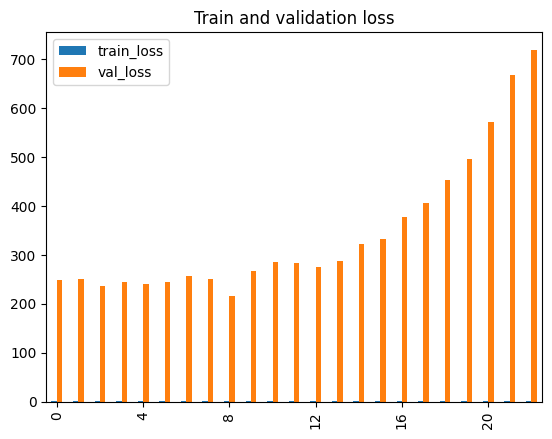

In [18]:
#************************ Data merge and train-test split
# Data merge
# Contrary to ARIMAX implementation lagged features and rolling means are kept in the dataset
compiled_data=h_covid_data.merge(h_weath_data,how="inner",on="Date",suffixes=["_covid","_weather"])
compiled_data.drop(["Year_covid","Year_weather","Month_covid","Day_covid","Date","Month_weather","Day_weather","Cases"],axis="columns",inplace=True)
compiled_data.dropna(inplace=True)
compiled_data.head()
model_data=compiled_data.copy() #Compiled data used to model purposes

train_val_data=model_data.loc[:int(0.8*len(model_data)),:]

#********************** Walk forward train and validation
#Time window definition
time_window=26*7 #Representing half year
time_step=7
val_size=30
n_steps=int((len(train_val_data)-time_window)/time_step)

#List to store parameters, train loss and validation loss
params=[]
train_loss=[]
val_loss=[]
scaler_list=[]
r2_list=[]

xgb_results=pd.DataFrame(columns=["train_loss","val_loss","test_loss"])

for step in range(n_steps):
    #set moving start and end positions for train and validation set
    train_start=step
    train_end=train_start+time_window

    if train_end + val_size + time_step > len(train_val_data): # Avoid index error at the end
        break  

    #Data split into train and validation
    train_data=train_val_data.loc[train_start:train_end,:]
    X_train=train_data.drop("Cases_Agg",axis="columns")
    y_train=train_data.Cases_Agg
    y_train_log=np.log1p(y_train)

    val_data=train_val_data.loc[train_end+1 : train_end+1+val_size,:]
    X_val=val_data.drop("Cases_Agg",axis="columns")
    y_val=val_data.Cases_Agg
    y_val_log=np.log1p(y_val)


    #Scaling data
    scaler=MinMaxScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_val_scaled=scaler.transform(X_val)
    scaler_list.append(scaler)

    #Model fit and validation
    xgb_model=XGBRegressor()
    xgb_model.fit(X_train_scaled,y_train_log)
    params.append(xgb_model.get_params())

    #train Loss compute
    train_pred=xgb_model.predict(X_train_scaled)
    train_portion_loss=root_mean_squared_error(y_train,np.expm1(train_pred))
    train_loss.append(train_portion_loss)

    #Validation Loss compute
    val_pred=xgb_model.predict(X_val_scaled)
    val_portion_loss=root_mean_squared_error(y_val,np.expm1(val_pred))
    val_loss.append(val_portion_loss)

    #R2 compute
    r2_list.append(r2_score(y_val,np.expm1(val_pred)))

#************************* Printing validation
print(f"Walk-forward Results \nMean Train RMSE {sum(train_loss)/len(train_loss)}\nMean validation RMSE: {sum(val_loss)/len(val_loss)}")
print(f"Average r2 score {sum(r2_list)/len(r2_list)}")
#Dataframe to store results
xgb_results["train_loss"]=train_loss
xgb_results["val_loss"]=val_loss


xgb_results[["train_loss","val_loss"]].plot(kind="bar")
plt.title("Train and validation loss")
plt.xticks(list(range(0,len(xgb_results),4)),[str(tick) for tick in list(range(0,len(xgb_results),4))]);

## XGB implementation with high regularization

Walk-forward Results 
Mean Train RMSE 35.23286946737361
Mean validation RMSE: 368.4997872392285
Average r2 score 0.06819690855559364


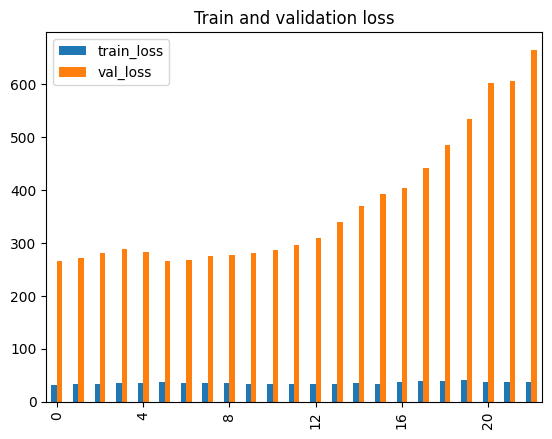

In [19]:
def model_train(in_data,model,time_window,time_step,val_size):
    '''   
    Description:
        Validates a time series forecasting model XGBoost using walk-forward validation.
        During each iteration, the model is trained on a rolling time window and validated on the following window.
        RMSE and R² scores are computed for each step to evaluate performance.

    Inputs:
        in_data (DataFrame): Full input dataset containing features and the target variable `Cases_Agg`.
        model (Regressor): An instantiated XGBRegressor 
        time_window (int): Number of time steps to use for each training window.
        time_step (int): Step size for shifting the time window in each iteration.
        val_size (int): Number of time steps to reserve for validation in each iteration.

    Returns:
        val_avg_error (float): Average validation RMSE across all walk-forward iterations.
        xgb_results (DataFrame): DataFrame with training and validation RMSEs per iteration.
        avg_r2 (float): Average R² score across all validation windows.
        model (Regressor): The model fitted on the final iteration of the walk-forward process.

    Note:
        - The returned model is only trained on the **last time window**, not the entire dataset.
        - The target variable is log-transformed during training for stability, and errors are computed on the original scale.
    '''
    #Train test split
    train_val_data=in_data.loc[:int(0.8*len(in_data)),:]

    #********************** Walk forward train and validation
    #Time window definitnion
    n_steps=int((len(train_val_data)-time_window)/time_step)

    #List to store parameters, train loss and validation loss
    train_loss=[]
    val_loss=[]
    scaler_list=[]
    r2_list=[]

    xgb_results=pd.DataFrame(columns=["train_loss","val_loss","test_loss"])

    for step in range(n_steps):
        #set moving start and end positions for train and validation set
        train_start=step
        train_end=train_start+time_window

        if train_end + val_size + time_step > len(train_val_data): # Avoid index error at the end
            break  

        #Data split into train and validation
        train_data=train_val_data.loc[train_start:train_end,:]
        X_train=train_data.drop("Cases_Agg",axis="columns")
        y_train=train_data.Cases_Agg
        y_train_log=np.log1p(y_train)

        val_data=train_val_data.loc[train_end+1 : train_end+1+val_size,:]
        X_val=val_data.drop("Cases_Agg",axis="columns")
        y_val=val_data.Cases_Agg
        y_val_log=np.log1p(y_val)


        #Scaling data
        scaler=MinMaxScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_val_scaled=scaler.transform(X_val)
        scaler_list.append(scaler)

        #Model fit and validation
        model.fit(X_train_scaled,y_train_log)
        params.append(model.get_params())

        #train Loss compute
        train_pred=model.predict(X_train_scaled)
        train_portion_loss=root_mean_squared_error(y_train,np.expm1(train_pred))
        train_loss.append(train_portion_loss)

        #Validation Loss compute
        val_pred=model.predict(X_val_scaled)
        val_portion_loss=root_mean_squared_error(y_val,np.expm1(val_pred))
        val_loss.append(val_portion_loss)

        #R2 compute
        r2_list.append(r2_score(y_val,np.expm1(val_pred)))

    #************************* storing train and validation loss
    train_avg_error=sum(train_loss)/len(train_loss)
    val_avg_error=sum(val_loss)/len(val_loss)
    avg_r2=sum(r2_list)/len(r2_list)
    print(f"Walk-forward Results \nMean Train RMSE {train_avg_error}\nMean validation RMSE: {val_avg_error}")
    print(f"Average r2 score {avg_r2}")
    #Dataframe to store results
    xgb_results["train_loss"]=train_loss
    xgb_results["val_loss"]=val_loss

    return val_avg_error,xgb_results,avg_r2,xgb_model

#Setting hyperparameters for XGB model
l2=5
l_rate=0.05
n_estimators=200
max_depth=3
xgb_model=XGBRegressor(reg_lambda=l2,learning_rate=l_rate,n_estimators=n_estimators,max_depth=max_depth)
_,xgb_results,r2,_=model_train(model_data,xgb_model,time_window=26*7,time_step=7,val_size=30)

#Printing validation
xgb_results[["train_loss","val_loss"]].plot(kind="bar")
plt.title("Train and validation loss")
plt.xticks(list(range(0,len(xgb_results),4)),[str(tick) for tick in list(range(0,len(xgb_results),4))]);


## XGB Optuna implementation

In [20]:
def xgb_val_r2(trial):
    '''
    Description:
        Objective function for Optuna to optimize hyperparameters of an XGBoost model using
        walk-forward validation. The evaluation metric is the average R² score across all validation windows.

    Inputs:
        trial (optuna.trial.Trial): A trial object representing a single evaluation of a set of hyperparameters.

    Returns:
        r2 (float): Average R² score from walk-forward validation using the current trial's parameters.

    Notes:
        - The function trains the model using the `model_train()` function, which applies
          log transformation to the target and walk-forward validation.
        - The best model (based on R²) is saved to disk in JSON format.
        - Relevant metadata (R² score and file path) are stored as user attributes in the trial.
    '''
    #Creating space study
    eta=trial.suggest_float("eta",1e-3,9e-1,log=True) # Learning rate range
    max_depth=trial.suggest_int("max_depth",2,16,step=2) # Drop probability for layer 1
    reg_lambda=trial.suggest_float("reg_lambda",1,10) # Drop probability for layer 2
    n_estimators=trial.suggest_int("n_estimators",100,400,step=10)

    #********************************** Model train and validation
    #Call function for walk-forward validation
    best_model=XGBRegressor(reg_lambda=reg_lambda,learning_rate=eta,n_estimators=n_estimators,max_depth=max_depth,random_state=42)
    _,_,r2,best_model=model_train(model_data,best_model,time_window=26*7,time_step=7,val_size=30)

    #Progress report
    trial.report(r2,step=trial.number)
    
    #Tracking
    trial.set_user_attr("r2_score", r2)

    #Save the best model
    if len(trial.study.best_trials) == 0 or r2 > trial.study.best_value:
        model_path = f"xgb_allfeat_r2_best_model_trial_{trial.number}.json"
        best_model.save_model(model_path)
        trial.set_user_attr("xgb_allfeat_r2_best_model_trial_", model_path)

    return r2

    
study=optuna.create_study(direction="maximize")  #Creating study case to maximize accuracy

#call the function to optimize
study.optimize(xgb_val_r2, n_trials=30)

# Get the best trial
print(f"Best trial:")
print(f"  Value (mean R2): {study.best_value}")
print(f"  Params: {study.best_params}")

# Loading the best model
xgb_r2_allfeat_best_trial = study.best_trial
xgb_r2_allfeat_model_path = xgb_r2_allfeat_best_trial.user_attrs["xgb_allfeat_r2_best_model_trial_"]
xgb_r2_allfeat_best_model = XGBRegressor()
xgb_r2_allfeat_best_model.load_model(xgb_r2_allfeat_model_path)



[I 2025-06-14 12:29:19,120] A new study created in memory with name: no-name-5ebcc046-f729-4da2-8dda-0d9e551eb494
[I 2025-06-14 12:29:32,522] Trial 0 finished with value: -1.042939063958217 and parameters: {'eta': 0.003227605677434487, 'max_depth': 16, 'reg_lambda': 8.225015999290141, 'n_estimators': 380}. Best is trial 0 with value: -1.042939063958217.


Walk-forward Results 
Mean Train RMSE 330.97090985682206
Mean validation RMSE: 547.9252920786615
Average r2 score -1.042939063958217


[I 2025-06-14 12:29:41,607] Trial 1 finished with value: -1.0793749428444088 and parameters: {'eta': 0.003849832376032859, 'max_depth': 6, 'reg_lambda': 5.306506775385836, 'n_estimators': 300}. Best is trial 0 with value: -1.042939063958217.


Walk-forward Results 
Mean Train RMSE 330.99659945972303
Mean validation RMSE: 546.3163942279252
Average r2 score -1.0793749428444088


[I 2025-06-14 12:29:44,372] Trial 2 finished with value: -0.26458300893008885 and parameters: {'eta': 0.3688664209176537, 'max_depth': 6, 'reg_lambda': 7.079634086684545, 'n_estimators': 190}. Best is trial 2 with value: -0.26458300893008885.


Walk-forward Results 
Mean Train RMSE 1.6476090761494249
Mean validation RMSE: 416.40018336950783
Average r2 score -0.26458300893008885


[I 2025-06-14 12:29:57,056] Trial 3 finished with value: -0.22180030967212813 and parameters: {'eta': 0.03754625644283591, 'max_depth': 12, 'reg_lambda': 5.2625343501085995, 'n_estimators': 230}. Best is trial 3 with value: -0.22180030967212813.


Walk-forward Results 
Mean Train RMSE 8.458744363762506
Mean validation RMSE: 403.19632917364714
Average r2 score -0.22180030967212813


[I 2025-06-14 12:30:14,297] Trial 4 finished with value: -0.20931443216309403 and parameters: {'eta': 0.007171177727409754, 'max_depth': 12, 'reg_lambda': 2.6534510404217784, 'n_estimators': 380}. Best is trial 4 with value: -0.20931443216309403.


Walk-forward Results 
Mean Train RMSE 101.81498584062354
Mean validation RMSE: 393.68518611364385
Average r2 score -0.20931443216309403


[I 2025-06-14 12:30:17,756] Trial 5 finished with value: -0.13208664303713635 and parameters: {'eta': 0.8597717552190267, 'max_depth': 16, 'reg_lambda': 1.5795532285355107, 'n_estimators': 270}. Best is trial 5 with value: -0.13208664303713635.


Walk-forward Results 
Mean Train RMSE 1.0943097657304768
Mean validation RMSE: 438.8644498428296
Average r2 score -0.13208664303713635


[I 2025-06-14 12:30:22,404] Trial 6 finished with value: -0.22376392513843185 and parameters: {'eta': 0.015223616453334997, 'max_depth': 4, 'reg_lambda': 5.893454918439419, 'n_estimators': 230}. Best is trial 5 with value: -0.13208664303713635.


Walk-forward Results 
Mean Train RMSE 96.21331454541733
Mean validation RMSE: 390.0552623222823
Average r2 score -0.22376392513843185


[I 2025-06-14 12:30:25,742] Trial 7 finished with value: -0.6209982518063729 and parameters: {'eta': 0.8626072105085629, 'max_depth': 16, 'reg_lambda': 7.302450665004679, 'n_estimators': 230}. Best is trial 5 with value: -0.13208664303713635.


Walk-forward Results 
Mean Train RMSE 1.4212848365894768
Mean validation RMSE: 492.9735979459652
Average r2 score -0.6209982518063729


[I 2025-06-14 12:30:32,319] Trial 8 finished with value: -0.35734957023164265 and parameters: {'eta': 0.15963635361334605, 'max_depth': 8, 'reg_lambda': 9.072642637808634, 'n_estimators': 370}. Best is trial 5 with value: -0.13208664303713635.


Walk-forward Results 
Mean Train RMSE 1.6731669699185674
Mean validation RMSE: 423.665183608193
Average r2 score -0.35734957023164265


[I 2025-06-14 12:30:35,789] Trial 9 finished with value: -2.429434611759787 and parameters: {'eta': 0.0011144593710735726, 'max_depth': 14, 'reg_lambda': 8.263534761280669, 'n_estimators': 110}. Best is trial 5 with value: -0.13208664303713635.


Walk-forward Results 
Mean Train RMSE 692.8800062596694
Mean validation RMSE: 817.6399135072699
Average r2 score -2.429434611759787


[I 2025-06-14 12:30:38,947] Trial 10 finished with value: 0.34822169244605566 and parameters: {'eta': 0.0745918842804107, 'max_depth': 2, 'reg_lambda': 1.1347655834473205, 'n_estimators': 310}. Best is trial 10 with value: 0.34822169244605566.


Walk-forward Results 
Mean Train RMSE 30.7233379120377
Mean validation RMSE: 340.44571134578894
Average r2 score 0.34822169244605566


[I 2025-06-14 12:30:42,236] Trial 11 finished with value: 0.3698858046253982 and parameters: {'eta': 0.08352605158986214, 'max_depth': 2, 'reg_lambda': 1.0387737159808201, 'n_estimators': 310}. Best is trial 11 with value: 0.3698858046253982.


Walk-forward Results 
Mean Train RMSE 26.30387496085382
Mean validation RMSE: 336.98135713243187
Average r2 score 0.3698858046253982


[I 2025-06-14 12:30:45,620] Trial 12 finished with value: 0.3174584799140025 and parameters: {'eta': 0.07251196253210995, 'max_depth': 2, 'reg_lambda': 3.1139306043270887, 'n_estimators': 320}. Best is trial 11 with value: 0.3698858046253982.


Walk-forward Results 
Mean Train RMSE 34.86276348008246
Mean validation RMSE: 345.05705758969816
Average r2 score 0.3174584799140025


[I 2025-06-14 12:30:48,879] Trial 13 finished with value: 0.3727522201617461 and parameters: {'eta': 0.09852869087955562, 'max_depth': 2, 'reg_lambda': 1.0685747747811187, 'n_estimators': 330}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 19.3587640231033
Mean validation RMSE: 335.26573009287904
Average r2 score 0.3727522201617461


[I 2025-06-14 12:30:52,534] Trial 14 finished with value: -0.027453333907350694 and parameters: {'eta': 0.18708995676717644, 'max_depth': 4, 'reg_lambda': 3.255618081446264, 'n_estimators': 350}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 1.920780328145874
Mean validation RMSE: 370.85408316635437
Average r2 score -0.027453333907350694


[I 2025-06-14 12:30:55,349] Trial 15 finished with value: 0.22808822703882212 and parameters: {'eta': 0.023403704575452766, 'max_depth': 2, 'reg_lambda': 2.137669480771444, 'n_estimators': 280}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 86.98337854385186
Mean validation RMSE: 352.6427501374355
Average r2 score 0.22808822703882212


[I 2025-06-14 12:31:12,484] Trial 16 finished with value: -0.1323401582393485 and parameters: {'eta': 0.06647823646491012, 'max_depth': 8, 'reg_lambda': 3.5284252954106283, 'n_estimators': 340}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 1.384987118067523
Mean validation RMSE: 388.1787372594223
Average r2 score -0.1323401582393485


[I 2025-06-14 12:31:16,866] Trial 17 finished with value: -0.005977269429907037 and parameters: {'eta': 0.30980059242405206, 'max_depth': 4, 'reg_lambda': 4.191389225695099, 'n_estimators': 170}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 1.8413024076419702
Mean validation RMSE: 377.7599898860792
Average r2 score -0.005977269429907037


[I 2025-06-14 12:31:24,040] Trial 18 finished with value: 0.18279443986624305 and parameters: {'eta': 0.1386848163568764, 'max_depth': 6, 'reg_lambda': 1.0407732622154153, 'n_estimators': 400}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 1.1847979187068594
Mean validation RMSE: 332.15719373611887
Average r2 score 0.18279443986624305


[I 2025-06-14 12:31:44,545] Trial 19 finished with value: -0.20847499820970572 and parameters: {'eta': 0.03718537107170406, 'max_depth': 10, 'reg_lambda': 4.232878509820934, 'n_estimators': 270}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 4.482783788795166
Mean validation RMSE: 397.1328301473404
Average r2 score -0.20847499820970572


[I 2025-06-14 12:31:54,098] Trial 20 finished with value: 0.0641154307125172 and parameters: {'eta': 0.014133094605964736, 'max_depth': 4, 'reg_lambda': 2.2578919530762187, 'n_estimators': 340}. Best is trial 13 with value: 0.3727522201617461.


Walk-forward Results 
Mean Train RMSE 37.59292630054681
Mean validation RMSE: 355.2820904956423
Average r2 score 0.0641154307125172


[I 2025-06-14 12:31:58,946] Trial 21 finished with value: 0.3840512363643157 and parameters: {'eta': 0.08114607695574447, 'max_depth': 2, 'reg_lambda': 1.0375610503129125, 'n_estimators': 310}. Best is trial 21 with value: 0.3840512363643157.


Walk-forward Results 
Mean Train RMSE 27.495475767764873
Mean validation RMSE: 334.2396223816715
Average r2 score 0.3840512363643157


[I 2025-06-14 12:32:03,214] Trial 22 finished with value: 0.36063894108910055 and parameters: {'eta': 0.07880585888052573, 'max_depth': 2, 'reg_lambda': 1.9064875635499505, 'n_estimators': 300}. Best is trial 21 with value: 0.3840512363643157.


Walk-forward Results 
Mean Train RMSE 32.20469774527658
Mean validation RMSE: 339.50551205493275
Average r2 score 0.36063894108910055


[I 2025-06-14 12:32:07,313] Trial 23 finished with value: 0.38888784479407335 and parameters: {'eta': 0.31344491953418535, 'max_depth': 2, 'reg_lambda': 1.013122753085485, 'n_estimators': 330}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 2.2466422943531117
Mean validation RMSE: 343.79212663986743
Average r2 score 0.38888784479407335


[I 2025-06-14 12:32:11,867] Trial 24 finished with value: 0.02918800820228178 and parameters: {'eta': 0.392345047658768, 'max_depth': 4, 'reg_lambda': 2.5850168286339215, 'n_estimators': 350}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 1.6712156893144847
Mean validation RMSE: 382.15733303962736
Average r2 score 0.02918800820228178


[I 2025-06-14 12:32:15,934] Trial 25 finished with value: -0.01982874514100209 and parameters: {'eta': 0.2960391642335145, 'max_depth': 6, 'reg_lambda': 1.7463464252719871, 'n_estimators': 330}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 1.3186650087340617
Mean validation RMSE: 366.7494112688926
Average r2 score -0.01982874514100209


[I 2025-06-14 12:32:19,599] Trial 26 finished with value: 0.3226827816145617 and parameters: {'eta': 0.12565625741876554, 'max_depth': 2, 'reg_lambda': 4.3340883781556645, 'n_estimators': 280}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 22.512047679102313
Mean validation RMSE: 343.54188817643893
Average r2 score 0.3226827816145617


[I 2025-06-14 12:32:22,852] Trial 27 finished with value: 0.16347545169051586 and parameters: {'eta': 0.21924756302419174, 'max_depth': 4, 'reg_lambda': 1.6405323013762647, 'n_estimators': 250}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 1.7778775387689627
Mean validation RMSE: 351.60932735155967
Average r2 score 0.16347545169051586


[I 2025-06-14 12:32:27,080] Trial 28 finished with value: -0.17072608085802127 and parameters: {'eta': 0.6342764596322183, 'max_depth': 8, 'reg_lambda': 2.7166907724641183, 'n_estimators': 400}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 1.2569887662704482
Mean validation RMSE: 411.2836212682819
Average r2 score -0.17072608085802127


[I 2025-06-14 12:32:31,658] Trial 29 finished with value: 0.30487268360526065 and parameters: {'eta': 0.049334948844254704, 'max_depth': 2, 'reg_lambda': 3.7620446850097093, 'n_estimators': 360}. Best is trial 23 with value: 0.38888784479407335.


Walk-forward Results 
Mean Train RMSE 46.77299593085685
Mean validation RMSE: 345.1994599599784
Average r2 score 0.30487268360526065
Best trial:
  Value (mean R2): 0.38888784479407335
  Params: {'eta': 0.31344491953418535, 'max_depth': 2, 'reg_lambda': 1.013122753085485, 'n_estimators': 330}


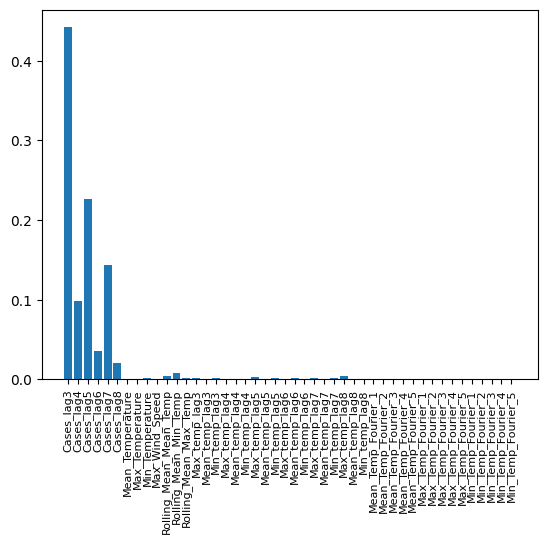

In [21]:
# Refit final model on full training data
X_train_val=train_val_data.drop("Cases_Agg",axis="columns")
y_train_val=train_val_data.Cases_Agg
y_train_val_log=np.log1p(y_train_val)
xgb_scaler=MinMaxScaler()
X_train_val_scaled=xgb_scaler.fit_transform(X_train_val)

final_model = XGBRegressor(**study.best_params, random_state=42)
final_model.fit(X_train_val_scaled, y_train_val_log)

#Plotting feature importance
plt.bar(x=X_train_val.columns,height=final_model.feature_importances_);
plt.xticks(rotation=90,fontsize=8);

## Light GBM implementation with default parameters

Walk-forward Results 
Mean Train RMSE 37.473393406233065
Mean validation RMSE: 369.58712791813537
Mean R2 0.13549190388812862


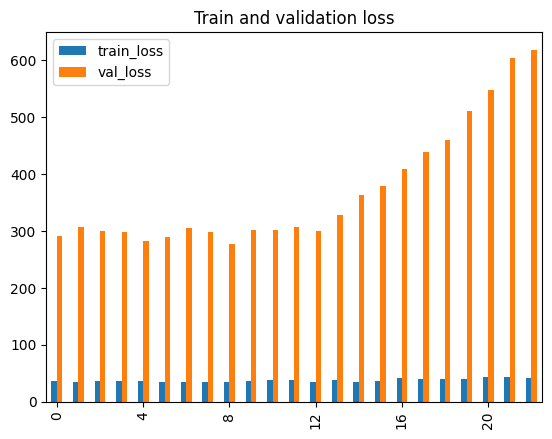

In [22]:
def lgbm_train(in_data,model,time_window=26*7,time_step=7,val_size=30):
    '''   
    Description:
        Validates a time series forecasting model LGBM using walk-forward validation.
        During each iteration, the model is trained on a rolling time window and validated on the following window.
        RMSE and R² scores are computed for each step to evaluate performance.

    Inputs:
        in_data (DataFrame): Full input dataset containing features and the target variable `Cases_Agg`.
        model (Regressor): An instantiated XGBRegressor 
        time_window (int): Number of time steps to use for each training window.
        time_step (int): Step size for shifting the time window in each iteration.
        val_size (int): Number of time steps to reserve for validation in each iteration.

    Returns:
        avg_val_loss (float): Average validation RMSE across all walk-forward iterations.
        lgb_results (DataFrame): DataFrame with training and validation RMSEs per iteration.
        model (Regressor): The model fitted on the final iteration of the walk-forward process.
        avg_r2 (float): Average R² score across all validation windows.

    Note:
        - The returned model is only trained on the **last time window**, not the entire dataset.
        - The target variable is log-transformed during training for stability, and errors are computed on the original scale.
    '''

    train_val_data=in_data.loc[:int(0.8*len(in_data)),:]

    #********************** Walk forward train and validation
    n_steps=int((len(train_val_data)-time_window)/time_step)

    #List to store train loss and validation loss
    train_loss=[]
    val_loss=[]
    scaler_list=[]
    r2_list=[]

    lgb_results=pd.DataFrame(columns=["train_loss","val_loss","test_loss"])

    for step in range(n_steps):
        #set moving start and end positions for train and validation set
        train_start=step
        train_end=train_start+time_window

        if train_end + val_size + time_step > len(train_val_data): # Avoid index error at the end
            break  

        #Data split into train and validation
        train_data=train_val_data.loc[train_start:train_end,:]
        X_train=train_data.drop("Cases_Agg",axis="columns")
        y_train=train_data.Cases_Agg
        y_train_log=np.log1p(y_train)

        val_data=train_val_data.loc[train_end+1 : train_end+1+val_size,:]
        X_val=val_data.drop("Cases_Agg",axis="columns")
        y_val=val_data.Cases_Agg

        #Scaling data
        scaler=MinMaxScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_val_scaled=scaler.transform(X_val)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
        scaler_list.append(scaler)

        #train Loss compute
        model.fit(X_train_scaled,y_train_log)
        train_pred=model.predict(X_train_scaled)
        train_portion_loss=root_mean_squared_error(y_train,np.expm1(train_pred))
        train_loss.append(train_portion_loss)

        #Validation Loss compute
        val_pred=model.predict(X_val_scaled)
        val_portion_loss=root_mean_squared_error(y_val,np.expm1(val_pred))
        val_loss.append(val_portion_loss)
        #R2 compute
        r2_list.append(r2_score(y_val,np.expm1(val_pred)))

    #************************* Printing validation
    avg_train_loss=sum(train_loss)/len(train_loss)
    avg_val_loss=sum(val_loss)/len(val_loss)
    avg_r2=sum(r2_list)/len(r2_list)
    print(f"Walk-forward Results \nMean Train RMSE {avg_train_loss}\nMean validation RMSE: {avg_val_loss}")
    print(f"Mean R2 {avg_r2}")
    
    #Dataframe to store results
    lgb_results["train_loss"]=train_loss
    lgb_results["val_loss"]=val_loss

    return avg_val_loss,lgb_results,model,avg_r2

model_data=compiled_data.copy() #Compiled data used to model purposes
lgbm_model=LGBMRegressor(verbosity=-1)  #Terminar de ajustar modelo

_,lgb_results,_,_=lgbm_train(model_data,lgbm_model,time_window=26*7,time_step=7,val_size=30)

lgb_results[["train_loss","val_loss"]].plot(kind="bar")
plt.title("Train and validation loss")
plt.xticks(list(range(0,len(lgb_results),4)),[str(tick) for tick in list(range(0,len(lgb_results),4))]);

# LGB Optuna implementation

In [23]:
def lgbm_val_r2(trial):
    '''
    Description:
        Objective function for Optuna to optimize hyperparameters of an LGBM model using
        walk-forward validation. The evaluation metric is the average R² score across all validation windows.

    Inputs:
        trial (optuna.trial.Trial): A trial object representing a single evaluation of a set of hyperparameters.

    Returns:
        r2 (float): Average R² score from walk-forward validation using the current trial's parameters.

    Notes:
        - The function trains the model using the `lgbm_train()` function, which applies
          log transformation to the target and walk-forward validation.
        - The best model (based on R²) is saved to disk in JSON format.
        - Relevant metadata (R² score and file path) are stored as user attributes in the trial.
    '''
    #Creating space study
    param = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "num_leaves": trial.suggest_int("num_leaves", 16, 512, step=16),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True)
    }

    #********************************** Model train and validation
    #Call function for walk-forward validation
    best_model=LGBMRegressor(**param,random_state=42,verbosity=-1)
    _,_,fitted_model,r2=lgbm_train(model_data,best_model,time_window=26*7,time_step=7,val_size=30)

    #Progress report
    trial.report(r2,step=trial.number)
    
    #Tracking
    trial.set_user_attr("r2_score", r2)

    #Save the best model
    if len(trial.study.best_trials) == 0 or r2 > trial.study.best_value:
        model_path = f"lgbm_best_r2_model_trial_{trial.number}.txt"
        booster = fitted_model.booster_
        booster.save_model(model_path)
        trial.set_user_attr("lgbm_r2_model_path", model_path)

    return r2

    
study=optuna.create_study(direction="maximize")  #Creating study case to maximize accuracy

#call the function to optimize
study.optimize(lgbm_val_r2, n_trials=30)

# Get the best trial
print(f"Best trial:")
print(f"  Value (mean R2): {study.best_value}")
print(f"  Params: {study.best_params}")

# Loading the best model
lgbm_model_path = study.best_trial.user_attrs["lgbm_r2_model_path"]
booster = lightgbm.Booster(model_file=lgbm_model_path)

# Create an LGBMRegressor and assign booster
lgbm_best_model = LGBMRegressor()
lgbm_best_model._Booster = booster
booster.free_dataset()

[I 2025-06-14 12:32:33,953] A new study created in memory with name: no-name-f2332eea-304e-4f3d-a358-06bb12f3bc7d
[I 2025-06-14 12:32:43,883] Trial 0 finished with value: 0.18624356774835746 and parameters: {'n_estimators': 1000, 'learning_rate': 0.044846966488524945, 'max_depth': 12, 'num_leaves': 400, 'reg_lambda': 0.004454724303472291}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 3.530137500996459
Mean validation RMSE: 368.57726586684106
Mean R2 0.18624356774835746


[I 2025-06-14 12:32:52,973] Trial 1 finished with value: -0.0821473550844832 and parameters: {'n_estimators': 1000, 'learning_rate': 0.002283992908838707, 'max_depth': 12, 'num_leaves': 240, 'reg_lambda': 0.06329530685951275}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 160.99408019289768
Mean validation RMSE: 383.2376158607127
Mean R2 -0.0821473550844832


[I 2025-06-14 12:32:55,884] Trial 2 finished with value: -1.331543331867763 and parameters: {'n_estimators': 300, 'learning_rate': 0.0013777367869976876, 'max_depth': 12, 'num_leaves': 32, 'reg_lambda': 0.0011798944715147657}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 545.9022493793115
Mean validation RMSE: 664.067011393132
Mean R2 -1.331543331867763


[I 2025-06-14 12:32:57,931] Trial 3 finished with value: -0.16671704254678704 and parameters: {'n_estimators': 200, 'learning_rate': 0.008795486943971375, 'max_depth': 7, 'num_leaves': 32, 'reg_lambda': 0.14534725517180974}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 215.0085286880975
Mean validation RMSE: 409.29425334925486
Mean R2 -0.16671704254678704


[I 2025-06-14 12:33:06,267] Trial 4 finished with value: -0.3086822452506659 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0013054337661695158, 'max_depth': 15, 'num_leaves': 176, 'reg_lambda': 0.030143054844318857}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 285.884476189558
Mean validation RMSE: 451.80755005055676
Mean R2 -0.3086822452506659


[I 2025-06-14 12:33:14,626] Trial 5 finished with value: 0.04688103130820882 and parameters: {'n_estimators': 900, 'learning_rate': 0.00699304572106789, 'max_depth': 8, 'num_leaves': 464, 'reg_lambda': 0.3222051914432}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 59.97504572281603
Mean validation RMSE: 380.7416837327542
Mean R2 0.04688103130820882


[I 2025-06-14 12:33:15,907] Trial 6 finished with value: -2.1228130852542293 and parameters: {'n_estimators': 100, 'learning_rate': 0.0015205030578681468, 'max_depth': 10, 'num_leaves': 432, 'reg_lambda': 0.025758285079721346}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 670.6295485623026
Mean validation RMSE: 786.7132594140254
Mean R2 -2.1228130852542293


[I 2025-06-14 12:33:23,731] Trial 7 finished with value: 0.07918986448571337 and parameters: {'n_estimators': 700, 'learning_rate': 0.013737130205143689, 'max_depth': 5, 'num_leaves': 320, 'reg_lambda': 0.8497829285153377}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 43.17735159719773
Mean validation RMSE: 380.009685954478
Mean R2 0.07918986448571337


[I 2025-06-14 12:33:39,140] Trial 8 finished with value: 0.17297513467175205 and parameters: {'n_estimators': 1000, 'learning_rate': 0.05246524459108162, 'max_depth': 11, 'num_leaves': 176, 'reg_lambda': 0.18188625486564572}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 2.5476137952559283
Mean validation RMSE: 371.27856765546136
Mean R2 0.17297513467175205


[I 2025-06-14 12:33:44,060] Trial 9 finished with value: -0.8751092992832527 and parameters: {'n_estimators': 400, 'learning_rate': 0.0020645956653372872, 'max_depth': 5, 'num_leaves': 208, 'reg_lambda': 2.7030922438244236}. Best is trial 0 with value: 0.18624356774835746.


Walk-forward Results 
Mean Train RMSE 426.09187956855203
Mean validation RMSE: 570.1385908311306
Mean R2 -0.8751092992832527


[I 2025-06-14 12:33:53,247] Trial 10 finished with value: 0.2786929036349727 and parameters: {'n_estimators': 700, 'learning_rate': 0.2165779766321112, 'max_depth': 16, 'num_leaves': 352, 'reg_lambda': 0.0016146455947070087}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.09505850188240483
Mean validation RMSE: 363.4195344125704
Mean R2 0.2786929036349727


[I 2025-06-14 12:34:05,732] Trial 11 finished with value: 0.2202532376333521 and parameters: {'n_estimators': 700, 'learning_rate': 0.29580090980906143, 'max_depth': 16, 'num_leaves': 352, 'reg_lambda': 0.0011231322398193386}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.0207617709704593
Mean validation RMSE: 372.6191899425268
Mean R2 0.2202532376333521


[I 2025-06-14 12:34:17,491] Trial 12 finished with value: 0.27023031838541917 and parameters: {'n_estimators': 700, 'learning_rate': 0.28257226798774443, 'max_depth': 16, 'num_leaves': 336, 'reg_lambda': 0.0011869455884485744}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.027052624153874858
Mean validation RMSE: 369.75140223315464
Mean R2 0.27023031838541917


[I 2025-06-14 12:34:27,892] Trial 13 finished with value: 0.27594166381251567 and parameters: {'n_estimators': 600, 'learning_rate': 0.20506871402460047, 'max_depth': 14, 'num_leaves': 512, 'reg_lambda': 0.006931115105070901}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.20316566797268473
Mean validation RMSE: 360.7934262508896
Mean R2 0.27594166381251567


[I 2025-06-14 12:34:34,583] Trial 14 finished with value: 0.17724472352778428 and parameters: {'n_estimators': 500, 'learning_rate': 0.10518244755900867, 'max_depth': 14, 'num_leaves': 496, 'reg_lambda': 0.0058113228287593865}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 2.4255391334093552
Mean validation RMSE: 369.23742716933907
Mean R2 0.17724472352778428


[I 2025-06-14 12:34:42,834] Trial 15 finished with value: 0.21420787491693827 and parameters: {'n_estimators': 600, 'learning_rate': 0.11398119561015063, 'max_depth': 14, 'num_leaves': 512, 'reg_lambda': 0.006990219055710634}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 1.2876823336617362
Mean validation RMSE: 364.7086797061733
Mean R2 0.21420787491693827


[I 2025-06-14 12:34:54,060] Trial 16 finished with value: 0.23105418400039388 and parameters: {'n_estimators': 800, 'learning_rate': 0.13009700125809187, 'max_depth': 14, 'num_leaves': 400, 'reg_lambda': 0.015682812586974276}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.3837536552482754
Mean validation RMSE: 363.55300675122913
Mean R2 0.23105418400039388


[I 2025-06-14 12:35:00,430] Trial 17 finished with value: 0.17211765284964647 and parameters: {'n_estimators': 500, 'learning_rate': 0.035335401307739045, 'max_depth': 16, 'num_leaves': 112, 'reg_lambda': 0.003347481221021137}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 18.56957821052297
Mean validation RMSE: 368.4124542697932
Mean R2 0.17211765284964647


[I 2025-06-14 12:35:11,262] Trial 18 finished with value: 0.24656174094099406 and parameters: {'n_estimators': 600, 'learning_rate': 0.18138639355391445, 'max_depth': 13, 'num_leaves': 288, 'reg_lambda': 0.010688053772709434}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.3282354751573114
Mean validation RMSE: 363.4025675326139
Mean R2 0.24656174094099406


[I 2025-06-14 12:35:26,806] Trial 19 finished with value: 0.19028363662507808 and parameters: {'n_estimators': 800, 'learning_rate': 0.07496248747132545, 'max_depth': 9, 'num_leaves': 384, 'reg_lambda': 0.002603247519694847}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 1.8249530811160282
Mean validation RMSE: 368.6317263998085
Mean R2 0.19028363662507808


[I 2025-06-14 12:35:34,225] Trial 20 finished with value: 0.11645578152194312 and parameters: {'n_estimators': 400, 'learning_rate': 0.02435381661285882, 'max_depth': 15, 'num_leaves': 464, 'reg_lambda': 0.05338819327193965}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 38.62833579069204
Mean validation RMSE: 374.2217859505965
Mean R2 0.11645578152194312


[I 2025-06-14 12:35:45,833] Trial 21 finished with value: 0.25957434257104717 and parameters: {'n_estimators': 700, 'learning_rate': 0.2637568672158997, 'max_depth': 16, 'num_leaves': 288, 'reg_lambda': 0.0018441899652649224}. Best is trial 10 with value: 0.2786929036349727.


Walk-forward Results 
Mean Train RMSE 0.03971262333018177
Mean validation RMSE: 370.12599822220324
Mean R2 0.25957434257104717


[I 2025-06-14 12:35:55,504] Trial 22 finished with value: 0.3300108796812617 and parameters: {'n_estimators': 800, 'learning_rate': 0.18218924692912986, 'max_depth': 3, 'num_leaves': 336, 'reg_lambda': 0.002262383356708199}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 0.7233735001787478
Mean validation RMSE: 354.3473885321156
Mean R2 0.3300108796812617


[I 2025-06-14 12:36:07,003] Trial 23 finished with value: 0.23559657062420672 and parameters: {'n_estimators': 800, 'learning_rate': 0.17549180051623386, 'max_depth': 4, 'num_leaves': 368, 'reg_lambda': 0.012577114203504908}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 0.24424295631565338
Mean validation RMSE: 361.6635404094191
Mean R2 0.23559657062420672


[I 2025-06-14 12:36:13,529] Trial 24 finished with value: 0.2776070550032583 and parameters: {'n_estimators': 600, 'learning_rate': 0.15783359841447617, 'max_depth': 3, 'num_leaves': 448, 'reg_lambda': 0.0024896240514773894}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 2.5166771636970853
Mean validation RMSE: 356.74812506173276
Mean R2 0.2776070550032583


[I 2025-06-14 12:36:25,117] Trial 25 finished with value: 0.26506121854453446 and parameters: {'n_estimators': 900, 'learning_rate': 0.06419310967859658, 'max_depth': 3, 'num_leaves': 432, 'reg_lambda': 6.453008183524989}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 10.933332683768741
Mean validation RMSE: 368.5107946027618
Mean R2 0.26506121854453446


[I 2025-06-14 12:36:41,544] Trial 26 finished with value: 0.20507476826441795 and parameters: {'n_estimators': 800, 'learning_rate': 0.10070972518141091, 'max_depth': 6, 'num_leaves': 304, 'reg_lambda': 0.0024231804197858754}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 0.8186903812197002
Mean validation RMSE: 364.6547577265228
Mean R2 0.20507476826441795


[I 2025-06-14 12:36:50,154] Trial 27 finished with value: 0.22218339247819632 and parameters: {'n_estimators': 500, 'learning_rate': 0.026905148481562998, 'max_depth': 3, 'num_leaves': 432, 'reg_lambda': 0.0033489622253175077}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 44.66812784967906
Mean validation RMSE: 365.3426312272259
Mean R2 0.22218339247819632


[I 2025-06-14 12:37:04,283] Trial 28 finished with value: 0.2135432309442051 and parameters: {'n_estimators': 900, 'learning_rate': 0.07901574202286699, 'max_depth': 4, 'num_leaves': 256, 'reg_lambda': 0.0019487074013502153}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 2.2708030281523848
Mean validation RMSE: 365.0044565689336
Mean R2 0.2135432309442051


[I 2025-06-14 12:37:17,473] Trial 29 finished with value: 0.18042829619158102 and parameters: {'n_estimators': 600, 'learning_rate': 0.04380258238022521, 'max_depth': 7, 'num_leaves': 352, 'reg_lambda': 0.004474246494689233}. Best is trial 22 with value: 0.3300108796812617.


Walk-forward Results 
Mean Train RMSE 9.861971499465387
Mean validation RMSE: 369.81020438966016
Mean R2 0.18042829619158102
Best trial:
  Value (mean R2): 0.3300108796812617
  Params: {'n_estimators': 800, 'learning_rate': 0.18218924692912986, 'max_depth': 3, 'num_leaves': 336, 'reg_lambda': 0.002262383356708199}


## Selected model cleaning

* XGB exhibit best performance during initial Optuna's implementation, and is selected as the model to deploy
* Only lagged COVID-19 cases are kept as relevant features according to the model's feature importance

In [25]:
model_data=compiled_data[["Cases_lag3","Cases_lag4","Cases_lag5","Cases_lag6","Cases_lag7","Cases_lag8","Cases_Agg"]]

study=optuna.create_study(direction="maximize")  #Creating study case to maximize accuracy

#call the function to optimize
study.optimize(xgb_val_r2, n_trials=30)

# Get the best trial
print(f"Best trial:")
print(f"  Value (mean R2): {study.best_value}")
print(f"  Params: {study.best_params}")

# Loading the best model
xgb_r2_best_trial = study.best_trial
xgb_r2_model_path = xgb_r2_best_trial.user_attrs["xgb_allfeat_r2_best_model_trial_"]
xgb_r2_best_model = XGBRegressor()
xgb_r2_best_model.load_model(xgb_r2_model_path)

[I 2025-06-14 12:39:11,238] A new study created in memory with name: no-name-dd794d4f-dbd0-406e-8a3b-4c2125ebeac5
[I 2025-06-14 12:39:17,921] Trial 0 finished with value: 0.7249865772058203 and parameters: {'eta': 0.20887476723321313, 'max_depth': 4, 'reg_lambda': 4.327204874028441, 'n_estimators': 370}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 3.8784008718174205
Mean validation RMSE: 241.5705676603895
Average r2 score 0.7249865772058203


[I 2025-06-14 12:39:25,797] Trial 1 finished with value: 0.7039336049398106 and parameters: {'eta': 0.2921837510253027, 'max_depth': 16, 'reg_lambda': 7.481924238885497, 'n_estimators': 320}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 2.539738998463119
Mean validation RMSE: 257.7228835500805
Average r2 score 0.7039336049398106


[I 2025-06-14 12:39:30,988] Trial 2 finished with value: -1.4039684323626218 and parameters: {'eta': 0.002391849964774622, 'max_depth': 6, 'reg_lambda': 7.667875538342689, 'n_estimators': 160}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 575.8014465537218
Mean validation RMSE: 687.3625934331948
Average r2 score -1.4039684323626218


[I 2025-06-14 12:39:43,127] Trial 3 finished with value: 0.6922919586177235 and parameters: {'eta': 0.03031148827219657, 'max_depth': 6, 'reg_lambda': 9.757463114367711, 'n_estimators': 330}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 36.23182133999792
Mean validation RMSE: 257.509727113065
Average r2 score 0.6922919586177235


[I 2025-06-14 12:39:46,816] Trial 4 finished with value: 0.6627493721579157 and parameters: {'eta': 0.6904209033811737, 'max_depth': 10, 'reg_lambda': 3.058231049275621, 'n_estimators': 260}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 2.0325138875752193
Mean validation RMSE: 281.9076573430039
Average r2 score 0.6627493721579157


[I 2025-06-14 12:39:54,828] Trial 5 finished with value: 0.7160437935849662 and parameters: {'eta': 0.09472609717790544, 'max_depth': 4, 'reg_lambda': 5.244240906733742, 'n_estimators': 320}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 13.054609056946322
Mean validation RMSE: 244.22459924364716
Average r2 score 0.7160437935849662


[I 2025-06-14 12:40:04,142] Trial 6 finished with value: 0.7091726385418953 and parameters: {'eta': 0.19598727910134042, 'max_depth': 14, 'reg_lambda': 8.370750471221474, 'n_estimators': 260}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 2.6750775108776805
Mean validation RMSE: 253.20843151638323
Average r2 score 0.7091726385418953


[I 2025-06-14 12:40:18,262] Trial 7 finished with value: 0.572384917381004 and parameters: {'eta': 0.010789689466905047, 'max_depth': 10, 'reg_lambda': 5.309559206471806, 'n_estimators': 280}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 121.93156219208008
Mean validation RMSE: 290.8488774075232
Average r2 score 0.572384917381004


[I 2025-06-14 12:40:26,172] Trial 8 finished with value: -1.1782677163600876 and parameters: {'eta': 0.0022076636647605846, 'max_depth': 16, 'reg_lambda': 5.934499689366851, 'n_estimators': 210}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 539.1998188109297
Mean validation RMSE: 650.7332438805639
Average r2 score -1.1782677163600876


[I 2025-06-14 12:40:41,139] Trial 9 finished with value: 0.7092273580027912 and parameters: {'eta': 0.058090598939648776, 'max_depth': 16, 'reg_lambda': 3.355993721902762, 'n_estimators': 170}. Best is trial 0 with value: 0.7249865772058203.


Walk-forward Results 
Mean Train RMSE 6.059938927239724
Mean validation RMSE: 250.5486590024138
Average r2 score 0.7092273580027912


[I 2025-06-14 12:40:46,903] Trial 10 finished with value: 0.7255436454313701 and parameters: {'eta': 0.8783055450105376, 'max_depth': 2, 'reg_lambda': 1.3231250047209793, 'n_estimators': 380}. Best is trial 10 with value: 0.7255436454313701.


Walk-forward Results 
Mean Train RMSE 2.9014421566454334
Mean validation RMSE: 269.95576305047234
Average r2 score 0.7255436454313701


[I 2025-06-14 12:40:55,586] Trial 11 finished with value: 0.7401765637721843 and parameters: {'eta': 0.8434209481256053, 'max_depth': 2, 'reg_lambda': 1.2314460879494793, 'n_estimators': 400}. Best is trial 11 with value: 0.7401765637721843.


Walk-forward Results 
Mean Train RMSE 2.900308900863899
Mean validation RMSE: 266.8141048196292
Average r2 score 0.7401765637721843


[I 2025-06-14 12:41:03,951] Trial 12 finished with value: 0.7164194614661035 and parameters: {'eta': 0.8735717263895009, 'max_depth': 2, 'reg_lambda': 1.009265406611581, 'n_estimators': 400}. Best is trial 11 with value: 0.7401765637721843.


Walk-forward Results 
Mean Train RMSE 2.7500454856632786
Mean validation RMSE: 274.07022447403466
Average r2 score 0.7164194614661035


[I 2025-06-14 12:41:06,854] Trial 13 finished with value: 0.7377771656686246 and parameters: {'eta': 0.526233543828717, 'max_depth': 2, 'reg_lambda': 1.0598878315736018, 'n_estimators': 100}. Best is trial 11 with value: 0.7401765637721843.


Walk-forward Results 
Mean Train RMSE 36.38990905544646
Mean validation RMSE: 253.84360729709778
Average r2 score 0.7377771656686246


[I 2025-06-14 12:41:12,848] Trial 14 finished with value: 0.01956524730368203 and parameters: {'eta': 0.011479270500742968, 'max_depth': 6, 'reg_lambda': 2.332355126552662, 'n_estimators': 100}. Best is trial 11 with value: 0.7401765637721843.


Walk-forward Results 
Mean Train RMSE 311.9972952488039
Mean validation RMSE: 428.30426550519707
Average r2 score 0.01956524730368203


[I 2025-06-14 12:41:16,509] Trial 15 finished with value: 0.7604991071292334 and parameters: {'eta': 0.3904169786984959, 'max_depth': 2, 'reg_lambda': 2.215624076287895, 'n_estimators': 130}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 42.704876965635165
Mean validation RMSE: 239.6687128463032
Average r2 score 0.7604991071292334


[I 2025-06-14 12:41:26,408] Trial 16 finished with value: 0.718789389061265 and parameters: {'eta': 0.1265921090941984, 'max_depth': 8, 'reg_lambda': 2.334892941741955, 'n_estimators': 210}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 2.0900632238674945
Mean validation RMSE: 244.7028010292777
Average r2 score 0.718789389061265


[I 2025-06-14 12:41:31,972] Trial 17 finished with value: 0.7157261948729577 and parameters: {'eta': 0.44729036348187073, 'max_depth': 4, 'reg_lambda': 3.703248104402097, 'n_estimators': 160}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 3.2299706657449825
Mean validation RMSE: 254.05026676400038
Average r2 score 0.7157261948729577


[I 2025-06-14 12:41:57,345] Trial 18 finished with value: 0.7146441250904287 and parameters: {'eta': 0.04798131949931417, 'max_depth': 12, 'reg_lambda': 2.2782818593899647, 'n_estimators': 210}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 3.224899187062969
Mean validation RMSE: 244.0065810341386
Average r2 score 0.7146441250904287


[I 2025-06-14 12:42:08,613] Trial 19 finished with value: 0.08515879157793994 and parameters: {'eta': 0.009913609906327253, 'max_depth': 8, 'reg_lambda': 4.3398713159351425, 'n_estimators': 140}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 282.5358773298983
Mean validation RMSE: 411.9629169016147
Average r2 score 0.08515879157793994


[I 2025-06-14 12:42:17,327] Trial 20 finished with value: 0.7241444082741013 and parameters: {'eta': 0.32012436671864336, 'max_depth': 4, 'reg_lambda': 2.3171143014152005, 'n_estimators': 350}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 3.3740971360657777
Mean validation RMSE: 243.32626902706434
Average r2 score 0.7241444082741013


[I 2025-06-14 12:42:20,756] Trial 21 finished with value: 0.758697039580924 and parameters: {'eta': 0.44393019390089666, 'max_depth': 2, 'reg_lambda': 1.4770130134538262, 'n_estimators': 100}. Best is trial 15 with value: 0.7604991071292334.


Walk-forward Results 
Mean Train RMSE 45.603360263094245
Mean validation RMSE: 244.51122736680168
Average r2 score 0.758697039580924


[I 2025-06-14 12:42:24,847] Trial 22 finished with value: 0.7697247583254044 and parameters: {'eta': 0.1577662741683241, 'max_depth': 2, 'reg_lambda': 1.759756636378806, 'n_estimators': 130}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 83.68641156529652
Mean validation RMSE: 226.38769664586937
Average r2 score 0.7697247583254044


[I 2025-06-14 12:42:28,517] Trial 23 finished with value: 0.7652200322185579 and parameters: {'eta': 0.13731387373824053, 'max_depth': 2, 'reg_lambda': 1.999923045517435, 'n_estimators': 130}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 89.50029377049461
Mean validation RMSE: 228.63194468387672
Average r2 score 0.7652200322185579


[I 2025-06-14 12:42:33,475] Trial 24 finished with value: 0.7220692869210203 and parameters: {'eta': 0.11648802189905808, 'max_depth': 4, 'reg_lambda': 2.9945113422250564, 'n_estimators': 130}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 29.49749800548256
Mean validation RMSE: 241.24942334560254
Average r2 score 0.7220692869210203


[I 2025-06-14 12:42:39,313] Trial 25 finished with value: 0.7013832358138039 and parameters: {'eta': 0.06692784556168017, 'max_depth': 6, 'reg_lambda': 4.026273890074236, 'n_estimators': 130}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 19.46448734381661
Mean validation RMSE: 253.4231511374054
Average r2 score 0.7013832358138039


[I 2025-06-14 12:42:42,832] Trial 26 finished with value: 0.7688848056468442 and parameters: {'eta': 0.16689503001963207, 'max_depth': 2, 'reg_lambda': 2.0312907430733276, 'n_estimators': 190}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 64.48530428337853
Mean validation RMSE: 225.17667031338453
Average r2 score 0.7688848056468442


[I 2025-06-14 12:42:48,009] Trial 27 finished with value: 0.7072421786510954 and parameters: {'eta': 0.027678749197051385, 'max_depth': 4, 'reg_lambda': 1.7414375041283414, 'n_estimators': 190}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 63.488430779165384
Mean validation RMSE: 238.2273276408301
Average r2 score 0.7072421786510954


[I 2025-06-14 12:42:53,236] Trial 28 finished with value: 0.764750390549379 and parameters: {'eta': 0.1659323693944932, 'max_depth': 2, 'reg_lambda': 2.901076208917776, 'n_estimators': 230}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 59.24837943032471
Mean validation RMSE: 228.31680908860494
Average r2 score 0.764750390549379


[I 2025-06-14 12:42:56,770] Trial 29 finished with value: 0.709783685281397 and parameters: {'eta': 0.25442305486759165, 'max_depth': 8, 'reg_lambda': 4.1081000250781186, 'n_estimators': 180}. Best is trial 22 with value: 0.7697247583254044.


Walk-forward Results 
Mean Train RMSE 2.382359780580209
Mean validation RMSE: 250.37355453080593
Average r2 score 0.709783685281397
Best trial:
  Value (mean R2): 0.7697247583254044
  Params: {'eta': 0.1577662741683241, 'max_depth': 2, 'reg_lambda': 1.759756636378806, 'n_estimators': 130}


Text(0.5, 1.0, 'Comparison between prediction and observation in train_validation set')

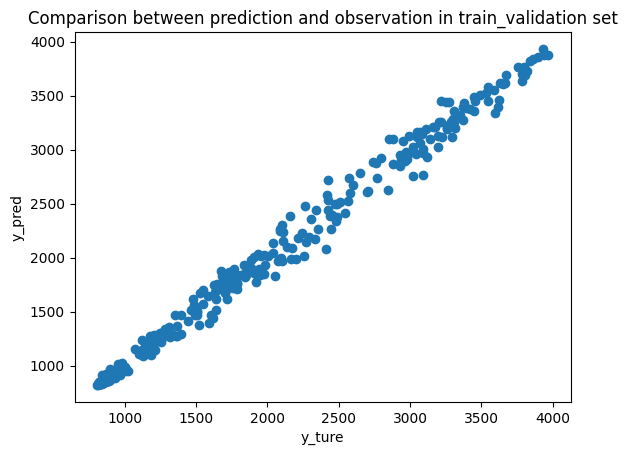

In [39]:
# Refit final model on full training data
X_train_val=train_val_data[["Cases_lag3","Cases_lag4","Cases_lag5","Cases_lag6","Cases_lag7","Cases_lag8"]]
y_train_val=train_val_data.Cases_Agg
y_train_val_log=np.log1p(y_train_val)
xgb_scaler=MinMaxScaler()
X_train_val_scaled=xgb_scaler.fit_transform(X_train_val)
joblib.dump(xgb_scaler, 'scaler.gz') #Dumping the scaler for future deployment

final_model = XGBRegressor(**study.best_params, random_state=42)
final_model.fit(X_train_val_scaled, y_train_val_log)
final_model.save_model('xgb_final_model.json') #Saving the final model

y_pred=final_model.predict(X_train_val_scaled)
plt.scatter(y_train_val,np.expm1(y_pred))
plt.xlabel("y_ture")
plt.ylabel("y_pred")
plt.title("Comparison between prediction and observation in train_validation set")

# Model testing

Highlights:
* The final model was tested, achieving an r2 score of 0.68 on unseen data.
* Residuals showed a central tendency close to zero, with most prediction errors falling within a ±20% margin.
* The model demonstrated stronger performance during periods of non-peak COVID-19 cases. Its accuracy during peak conditions could likely be improved by incorporating additional training data or engineered features to better capture extreme variations.
* Residuals show a distribution centered around zero, with nearly all normalized residuals falling between -2 and 2. This indicates a lack of extreme outliers. Residual dispersion tends to increase with higher case counts, a known challenge in epidemic forecasting due to the unpredictable nature of peaks


## XGB Test



Test RMSE 66.9921
Test R2 0.7761


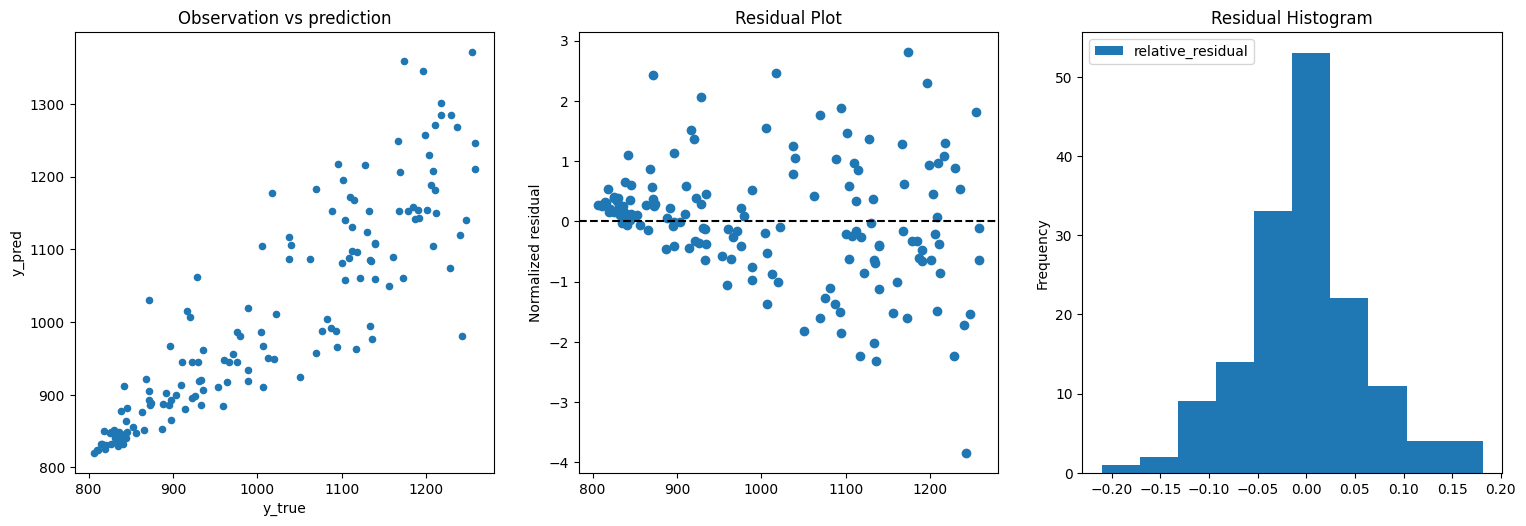

In [37]:
def model_test(scaler,test_data,model):
      '''
      Description:
        Evaluates a pretrained regression model on a test dataset using RMSE and r2 metrics.
        Applies the same scaler used during training and visualizes prediction quality and residuals.

      Inputs:
        scaler (sklearn.preprocessing object): The MinMaxScaler (or similar) fitted on the training data.
        test_data (DataFrame): DataFrame containing input features and the target variable `Cases_Agg`.
        model (Regressor): Trained regression model (e.g., XGBRegressor or LGBMRegressor).

      Returns:
        results (DataFrame): DataFrame with the following columns:
            - y_true: Actual target values from the test set.
            - y_pred: Model predictions (converted back from log scale).
            - residual: Difference between prediction and actual.
            - relative_residual: Residual expressed as a percentage of the true value.

      Notes:
        - Predictions are assumed to be made on log-transformed targets, and are inverse-transformed using `np.expm1()`.
        - Three diagnostic plots are shown: predictions vs. actuals, residuals vs. actuals, and histogram of relative residuals.
      '''
      # ****************** Getting X and y data for test set
      X_test=test_data.drop("Cases_Agg",axis="columns")
      y_test=test_data.Cases_Agg

      # Scaling data using train and validation sets
      X_test_scaled=scaler.transform(X_test)

      # ******************** Test set evaluation 
      # test predicition and RMSE calculation
      test_pred=model.predict(X_test_scaled)
      test_loss=root_mean_squared_error(y_test,np.expm1(test_pred))
      r2=r2_score(y_test,np.expm1(test_pred))

      # ******************** Plotting validations
      results=pd.DataFrame({"y_true":y_test,"y_pred":np.expm1(test_pred)})
      results["residual"]=results.y_pred-results.y_true
      results["relative_residual"]=results.residual/results.y_true


      fig,axs=plt.subplots(1,3,figsize=(15,5))
      plt.tight_layout(w_pad=3)
      #Scatter plot
      results[["y_true","y_pred"]].plot(kind="scatter",x="y_true",y="y_pred",ax=axs[0])
      axs[0].set_title("Observation vs prediction")

      #Residual
      axs[1].scatter(results.y_true,(results.residual-results.residual.mean())/(results.residual.std()))
      axs[1].axhline(y=0,color="black",linestyle="--")
      axs[1].set_ylabel("Normalized residual")
      axs[1].set_title("Residual Plot")

      #Normalized residual histogram
      results[["relative_residual"]].plot(kind="hist",ax=axs[2])
      axs[2].set_title("Residual Histogram")

      print(f"Test RMSE {test_loss:.4f}")
      print(f"Test R2 {r2:.4f}")

      return results

model_data=compiled_data[["Cases_lag3","Cases_lag4","Cases_lag5","Cases_lag6","Cases_lag7","Cases_lag8","Cases_Agg"]]
test_data=model_data.loc[int(0.8*len(train_val_data))+1:,:]
results=model_test(xgb_scaler,test_data,final_model)